In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q  vcdx torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import networkx as nx
import time
from datetime import datetime
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, DataLoader
import torch.optim as optim
import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE

import sklearn.metrics as metrics 

import matplotlib.pyplot as plt

In [3]:
# Define a function to pad or truncate the vectors to a fixed length
def pad_or_truncate_vector(vector, length):
    if len(vector) < length:
        return vector + [0] * (length - len(vector))
    elif len(vector) > length:
        return vector[:length]
    else:
        return vector

In [105]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.input_dim = input_dim
        self.output_dim = output_dim

    def encode(self, x):
        # Encode the input
        hidden = self.encoder(x)
        mean, log_var = torch.chunk(hidden, 2, dim=-1)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        # Decode the latent variable
        decoded = self.decoder(z)
        return decoded

    def forward(self, x, mask=None):
        # Forward pass through the VAE
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        decoded = self.decode(z)

        # Apply mask to ignore padded zeros
        if mask is not None:
            decoded = decoded * mask.unsqueeze(2)  # Multiply by the mask

        return decoded, mean, log_var

In [106]:
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.input_dim = input_dim
        self.output_dim = output_dim

    def encode(self, x):
        # Encode the input
        hidden = self.encoder(x)
        return hidden

    def decode(self, z):
        # Decode the latent variable
        decoded = self.decoder(z)
        return decoded

    def forward(self, x, mask=None):
        # Forward pass through the autoencoder
        encoded = self.encode(x)
        decoded = self.decode(encoded)

        # Apply mask to ignore padded zeros
        if mask is not None:
            decoded = decoded * mask.unsqueeze(2)  # Multiply by the mask

        return decoded

In [4]:
import torch
import torch.nn as nn

class AEL(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(AEL, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.2),  # Adding LeakyReLU activation function
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2),  # Adding LeakyReLU activation function
            nn.Linear(hidden_dim2, latent_dim)
        )

        self.input_dim = input_dim
        self.latent_dim = latent_dim

    def encode(self, x):
        # Encode the input
        hidden = self.encoder(x)
        return hidden

    def forward(self, x, mask=None):
        # Forward pass through the autoencoder
        encoded = self.encode(x)
        # Apply mask to ignore padded zeros
        if mask is not None:
            encoded = encoded * mask.unsqueeze(2)  # Multiply by the mask
        return encoded

In [5]:
def split_and_convert(value):
    if pd.isna(value) or not isinstance(value, str):
        return []
    else:
        # Split the string and convert each element to float if possible
        values = value.split('|')
        numeric_values = []
        for val in values:
            try:
                numeric_val = float(val)
                numeric_values.append(numeric_val)
            except ValueError:
                pass  # Skip non-numeric values
        return numeric_values

In [376]:
#READ DATA

LOC   = "/Users/arthurdai/Desktop/Fighting/TCGA_integrative"
CANCER = "BLCA"
PPI   = f'{LOC}/{CANCER}/{CANCER}_PPI.csv'
GS = f'{LOC}/{CANCER}/{CANCER}_GS.csv'
ID = f'{LOC}/{CANCER}/{CANCER}_ID.csv'
Cluster = f'{LOC}/{CANCER}/{CANCER}_im_cluster.csv'
HRD = f'{LOC}/{CANCER}/{CANCER}_hrd.csv'
Stem = f'{LOC}/{CANCER}/{CANCER}_stem.csv'
Survival = f'{LOC}/{CANCER}/{CANCER}_survival.csv'
Stage = f'{LOC}/{CANCER}/{CANCER}_stage.csv'
FEATURES = [f'{LOC}/{CANCER}/{CANCER}_EXP.csv', f'{LOC}/{CANCER}/{CANCER}_CNV.csv',
f'{LOC}/{CANCER}/{CANCER}_MUT.csv', f'{LOC}/{CANCER}/{CANCER}_cpgisland.csv', f'{LOC}/{CANCER}/{CANCER}_non_cpgisland.csv',
f'{LOC}/{CANCER}/{CANCER}_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_non_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_enhancer.csv']


#Import multi-omics files
gs = pd.read_csv(GS, index_col=0)
#node = pd.read_csv(Node, index_col=0)
exp = pd.read_csv(FEATURES[0], index_col=0).reindex(gs.index)
id = pd.read_csv(ID, index_col=1)

Cluster = pd.read_csv(Cluster, index_col=0).reindex(id.index).Cluster
HRD = pd.read_csv(HRD, index_col=0).reindex(id.index).HRD_group
Stem = pd.read_csv(Stem, index_col=0).reindex(id.index).RNAss_group
Survival = pd.read_csv(Survival, index_col=0).reindex(id.index).OS_group
Stage = pd.read_csv(Stage, index_col=0).reindex(id.index).patho_stage

feats = []

for path in FEATURES:
      feat_df = pd.read_csv(path, index_col=0) 
      feat_df = feat_df.reindex(gs.index, fill_value=0)
      feat_df = feat_df.transpose()
      feats.append(feat_df)

#For feature 2-4
for i in range(1,3):
    feat_df = feats[i].reindex(id.index, fill_value=0)
    feats[i] = feat_df

#For feature 5-9
for i in range(3,8):
    feat_df = feats[i].reindex(id.index, fill_value=0)
    #Create list
    new_df = feat_df.applymap(split_and_convert)
    
    ls = new_df.values.tolist()
    
    for row in ls:
      lengths = [len(subset) for subset in row]
      max_length = max(lengths)
      
      # Create the VAE model
      input_dim = max_length  # Dimension of the output vector
      hidden_dim = 64  # Hidden layer dimension
      latent_dim = 16  # Latent variable dimension
      output_dim = 1
      #vae = VAE(input_dim, hidden_dim, latent_dim, output_dim)
      #ae = AE(input_dim, hidden_dim, latent_dim, output_dim)
      ael = AEL(input_dim, hidden_dim1=64, hidden_dim2=32, latent_dim=1)
    
    #Use VAE to ouput feature values
    with torch.no_grad():
        x_padded = []
        for row in new_df.values.tolist():
            padded_row = [pad_or_truncate_vector(vector, max_length) for vector in row]
            x_padded.append(padded_row)
        x = torch.tensor(x_padded, dtype=torch.float)
        torch.manual_seed(1234)
        #decoded, _, _ = vae(x)
        decoded = ael(x)
        if output_dim > 1:
         # Convert the decoded tensor to a nested list with length 3
            decoded_list = [[vector.tolist() for vector in row] for row in decoded]

        else:
            decoded_list = [[vector.tolist()[0] for vector in row] for row in decoded]


    # Convert the nested list to a DataFrame
        decoded_df = pd.DataFrame(decoded_list, columns=new_df.columns, index=new_df.index)

        feats[i] = decoded_df

exp_new = exp.transpose().reindex(id.index)
#Standardization of expression value
#columns = exp_new.columns
#exp_new[columns] = scaler.fit_transform(exp_new)

feats[0] = exp_new


In [779]:
##Save feats0 for subsequent wgcna analysis in R
feats[0].to_csv(f'{LOC}/{CANCER}/{CANCER}_feats0.csv')

In [377]:
# old_cols are gene names
old_cols = feats[0].columns.values
    # old rows are patient names    
old_rows = feats[0].index.values
    # new_cols are ids 0:n.genes
new_cols = pd.factorize(old_cols)[0]
    # new_rows are ids 0:n.patients
new_rows = pd.factorize(old_rows)[0]

    # Mapping between genes and ids 
col_pairs = {name: no for name,no in zip(old_cols, new_cols)}
    # Mapping between patient names and ids
row_pairs = {name: no for name,no in zip(old_rows, new_rows)}

    # Harmonize/Reduce PPI with feature matrix
#ppi = ppi[ppi[ppi.columns.values[0]].isin(old_cols)]
#ppi = ppi[ppi[ppi.columns.values[1]].isin(old_cols)]

    #print(ppi)
    # convert genes to node ids
#ppi[ppi.columns.values[0]] = ppi[ppi.columns.values[0]].map(col_pairs)
#ppi[ppi.columns.values[1]] = ppi[ppi.columns.values[1]].map(col_pairs)    

    # col_pairs --> node ids + gene names!


#edge_index = ppi[[ppi.columns.values[0], ppi.columns.values[1]]].to_numpy()
    #print(edge_index)
    # convert to a proper format and sort
#edge_index = np.array(sorted(edge_index, key = lambda x: (x[0], x[1]))).T

gene_pairs ={value: key for key, value in col_pairs.items()}
gene_pairs

{0: 'FKBP5',
 1: 'TRAF1',
 2: 'TNFAIP8',
 3: 'TSPAN32',
 4: 'PLGRKT',
 5: 'STOM',
 6: 'SUSD3',
 7: 'IFITM2',
 8: 'SLC31A2',
 9: 'TRIM21',
 10: 'ADAM28',
 11: 'CD274',
 12: 'NEK6',
 13: 'ARL4C',
 14: 'SP110',
 15: 'TRIM22',
 16: 'ITK',
 17: 'CREM',
 18: 'GCNT1',
 19: 'DDX58',
 20: 'PHF11',
 21: 'SIGLEC14',
 22: 'IFITM3',
 23: 'SIRPB1',
 24: 'HAVCR2',
 25: 'AKIRIN2',
 26: 'HLA-DRB5',
 27: 'ACTB',
 28: 'IFNB1',
 29: 'PDCD1LG2',
 30: 'CTSL',
 31: 'SPAG6',
 32: 'SP100',
 33: 'PPP1R18',
 34: 'IFITM1',
 35: 'PML',
 36: 'ST6GALNAC6',
 37: 'GSN',
 38: 'STXBP1',
 39: 'NCS1',
 40: 'RGS16',
 41: 'ANXA2',
 42: 'AHNAK',
 43: 'LIX1L',
 44: 'XCL1',
 45: 'MSANTD3',
 46: 'ROR2',
 47: 'EVC2',
 48: 'C10orf55',
 49: 'S1PR3',
 50: 'LSM1',
 51: 'HHEX',
 52: 'GAS1',
 53: 'BAG4',
 54: 'SH3PXD2A',
 55: 'CUEDC1',
 56: 'DDHD2',
 57: 'IGF2BP3',
 58: 'EXT1',
 59: 'CNTLN',
 60: 'SMIM3',
 61: 'CDKN2A',
 62: 'SOX9',
 63: 'NFIL3',
 64: 'FOXE1',
 65: 'LPIN2',
 66: 'CXXC5',
 67: 'SLC25A25',
 68: 'PHF19',
 69: 'ENAH',
 70

In [8]:
###Convert feature dataframes with vector 
def flatten_list_iterative(lst):
    flattened_list = []
    stack = [lst]
    while stack:
        item = stack.pop()
        if isinstance(item, list):
            stack.extend(item)
        else:
            flattened_list.append(item)
    return flattened_list[::-1]

def flatten_array(arr):
    lst = arr.tolist()  # Convert the NumPy array to a list
    return flatten_list_iterative(lst) 

In [9]:
#Create cancer_graph_object

def cancer_graph_list(feats, node_feature_num, sample_size, node_number):
    new_temp = []
    feat_stack = np.stack(feats, axis=-1)
    empty_array = np.empty((sample_size, node_number, node_feature_num))
    for i in range(sample_size):
        for j in range(node_number):
            flattened_list = flatten_array(feat_stack[i, j, :])
            if len(flattened_list) == node_feature_num:
                empty_array[i, j, :] = flattened_list
            else:
                if len(flattened_list) > node_feature_num:
                    flattened_list = flattened_list[:node_feature_num] 
                else:
                    flattened_list += [0] * (node_feature_num - len(flattened_list))  # Pad the list with zeros
                    empty_array[i, j, :] = flattened_list

    for item in empty_array:
        new_temp.append(item)
        temp = np.array(new_temp)
    return temp

In [378]:
from torch_geometric.utils import to_undirected
exp_matrix = feats[0].transpose()
num_genes = len(exp_matrix)
ae_space_dim = 1
node_feature_num = 3 + (len(feats)-3)*ae_space_dim
sample_size = len(feats[0])
node_number = len(feats[0].columns)
feats = feats
graph = cancer_graph_list(feats, node_feature_num, sample_size, node_number)


In [11]:
##Pearson Co expression network

# Calculate correlation coefficients
correlation_matrix = np.corrcoef(exp_matrix)
threshold = 0.344

# Construct network based on correlation coefficients
G = nx.Graph()
for i in range(num_genes):
    for j in range(i+1, num_genes):
        correlation_coefficient = correlation_matrix[i, j]
        if abs(correlation_coefficient) > threshold:
            G.add_edge(i, j, weight=correlation_coefficient)

# Convert network to PyTorch Geometric Data object
edge_index = []
edge_attr = []
for u, v, data in G.edges(data=True):
    edge_index.append([u, v])
    edge_attr.append([data['weight']])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

edge_index, edge_attr = to_undirected(edge_index, edge_attr)



graphs = []
Label = Stem
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index, dtype=torch.long),
                       edge_attr = torch.tensor(edge_attr, dtype=torch.float),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           

G = graphs[0]
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')
g = pyg_utils.to_networkx(G, to_undirected = True)
node_degrees = dict(nx.degree(g))
highest_degree_gene = [node for node, degree in node_degrees.items() if degree == max(node_degrees.values())]
print(highest_degree_gene)
gene_pairs[highest_degree_gene[0]]

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of nodes: 616
Number of edges: 41386
Average node degree: 67.19
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True
[572, 574]


'ATP8B1'

In [790]:
#Distance correlation network
import dcor

data = exp_matrix.values
threshold = 0.35
# Calculate correlation coefficients
correlation_matrix = np.zeros((num_genes, num_genes))
for i in range(num_genes):
    for j in range(i, num_genes):  # Use j=i to avoid redundant calculations (symmetric matrix)
        gene_pair_correlation = dcor.distance_correlation(data[i], data[j])
        correlation_matrix[i, j] = gene_pair_correlation
        correlation_matrix[j, i] = gene_pair_correlation 


# Construct network based on correlation coefficients
G = nx.Graph()
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        correlation_coefficient = correlation_matrix[i, j]
        if correlation_coefficient > threshold:
            G.add_edge(i, j, weight=correlation_coefficient)

# Convert network to PyTorch Geometric Data object
edge_index_dc = torch.tensor(list(G.edges())).t().contiguous()
edge_attr_dc = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float).view(-1, 1)
edge_index_dc, edge_attr_dc = to_undirected(edge_index_dc, edge_attr_dc)

#correlation_matrix.to_csv('COAD_distance.csv')
graphs = []
Label = Stem
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index_dc, dtype=torch.long),
                       edge_attr = torch.tensor(edge_attr_dc, dtype=torch.float),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           

G = graphs[0]
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')
g = pyg_utils.to_networkx(G, to_undirected = True)
node_degrees = dict(nx.degree(g))
highest_degree_gene = [node for node, degree in node_degrees.items() if degree == max(node_degrees.values())]
print(highest_degree_gene)
gene_pairs[highest_degree_gene[0]]

Number of nodes: 215
Number of edges: 4438
Average node degree: 20.64
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True
[34]


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


'SYNE1'

In [802]:
# FOR ADJUSTMENT OF coefficients
threshold = 0.362
G = nx.Graph()
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        correlation_coefficient = correlation_matrix[i, j]
        if correlation_coefficient > threshold:
            G.add_edge(i, j, weight=correlation_coefficient)

# Convert network to PyTorch Geometric Data object
edge_index_dc = torch.tensor(list(G.edges())).t().contiguous()
edge_attr_dc = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float).view(-1, 1)
edge_index_dc, edge_attr_dc = to_undirected(edge_index_dc, edge_attr_dc)

#correlation_matrix.to_csv('COAD_distance.csv')
graphs = []
Label = Stem
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index_dc, dtype=torch.long),
                       edge_attr = torch.tensor(edge_attr_dc, dtype=torch.float),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           

G = graphs[0]
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')
g = pyg_utils.to_networkx(G, to_undirected = True)
node_degrees = dict(nx.degree(g))
highest_degree_gene = [node for node, degree in node_degrees.items() if degree == max(node_degrees.values())]
print(highest_degree_gene)
gene_pairs[highest_degree_gene[0]]

Number of nodes: 215
Number of edges: 3938
Average node degree: 18.32
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True
[34]


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


'SYNE1'

In [803]:
x = pd.DataFrame(correlation_matrix)
x.to_csv(f'{LOC}/{CANCER}/{CANCER}_dcor.csv')

In [11]:
#Pearson  WGCNA
correlation_matrix = pd.read_csv(f'{LOC}/{CANCER}/{CANCER}_pearson_wgcna.csv', index_col=0).values
threshold = 0.031

# Construct network based on correlation coefficients
G = nx.Graph()
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        correlation_coefficient = correlation_matrix[i, j]
        if correlation_coefficient > threshold:
            G.add_edge(i, j, weight=correlation_coefficient)

# Convert network to PyTorch Geometric Data object
edge_index_pw = torch.tensor(list(G.edges())).t().contiguous()
edge_attr_pw = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float).view(-1, 1)
edge_index_pw, edge_attr_pw = to_undirected(edge_index_pw, edge_attr_pw)

graphs = []
Label = Cluster
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index_pw, dtype=torch.long),
                       edge_attr = torch.tensor(edge_attr_pw, dtype=torch.float),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           

G = graphs[0]
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')
g = pyg_utils.to_networkx(G, to_undirected = True)
node_degrees = dict(nx.degree(g))
highest_degree_gene = [node for node, degree in node_degrees.items() if degree == max(node_degrees.values())]
print(highest_degree_gene)
gene_pairs[highest_degree_gene[0]]

Number of nodes: 290
Number of edges: 4128
Average node degree: 14.23
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True
[3, 110]


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


'STAG2'

In [379]:
#Distance WGCNA
correlation_matrix = pd.read_csv(f'{LOC}/{CANCER}/{CANCER}_distance_wgcna.csv', index_col=0).values

threshold = 0.067
# Construct network based on correlation coefficients
G = nx.Graph()
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        correlation_coefficient = correlation_matrix[i, j]
        if correlation_coefficient > threshold:
            G.add_edge(i, j, weight=correlation_coefficient)

# Convert network to PyTorch Geometric Data object
edge_index_dw = torch.tensor(list(G.edges())).t().contiguous()
edge_attr_dw = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float).view(-1, 1)
edge_index_dw, edge_attr_dw = to_undirected(edge_index_dw, edge_attr_dw)

graphs = []
Label = Stem
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index_dw, dtype=torch.long),
                       edge_attr = torch.tensor(edge_attr_dw, dtype=torch.float),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           

G = graphs[0]
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')
g = pyg_utils.to_networkx(G, to_undirected = True)
node_degrees = dict(nx.degree(g))
highest_degree_gene = [node for node, degree in node_degrees.items() if degree == max(node_degrees.values())]
print(highest_degree_gene)
gene_pairs[highest_degree_gene[0]]


Number of nodes: 616
Number of edges: 4904
Average node degree: 7.96
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True
[574]


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


'TRAK1'

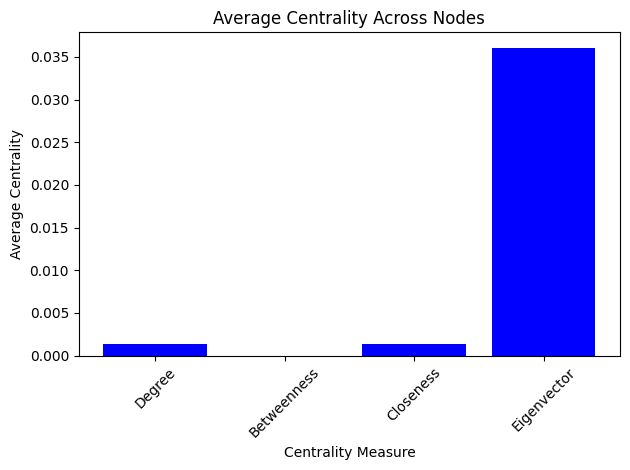

In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a graph from edge indices
def create_graph_from_edge_indices(edge_index, num_genes):
    G = nx.Graph()
    G.add_nodes_from(range(num_genes))
    G.add_edges_from(edge_index.T)
    return G

# Create a graph from edge indices
graph = create_graph_from_edge_indices(edge_index, num_genes)

# Calculate node characteristics
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
closeness_centrality = nx.closeness_centrality(graph)
eigenvector_centrality = nx.eigenvector_centrality(graph)

# Calculate average centrality values
avg_degree = np.mean(list(degree_centrality.values()))
std_degree = np.std(list(degree_centrality.values()))
avg_betweenness = np.mean(list(betweenness_centrality.values()))
avg_closeness = np.mean(list(closeness_centrality.values()))
avg_eigenvector = np.mean(list(eigenvector_centrality.values()))

In [239]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora/PPI)
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment it's out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('degree count'); plt.title('Degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('degree count'); plt.title('Degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree'); plt.ylabel('# nodes for a given degree'); plt.title(f'Node degree distribution')
    plt.xticks(np.arange(0, len(hist), 20.0))

    plt.grid(True)
    plt.show()

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

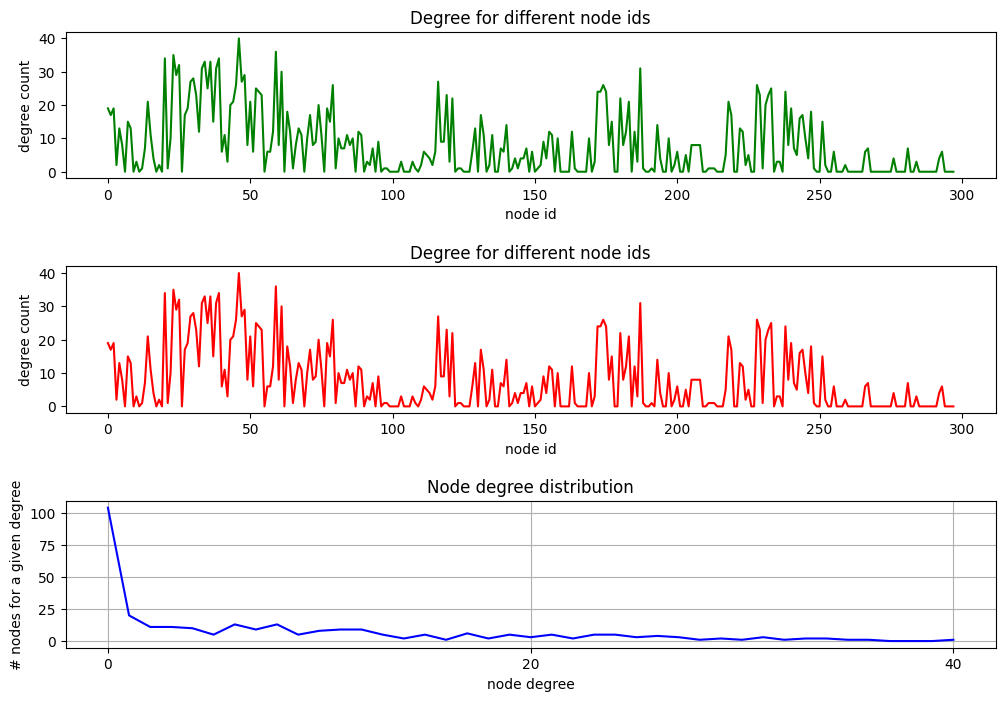

In [241]:
num_of_nodes = 298
plot_in_out_degree_distributions(edge_index_dw, num_of_nodes)

In [487]:
df = pd.read_csv(f'{LOC}/{CANCER}/{CANCER}_enhancer.csv', index_col=0)

def convert_to_numeric_list(cell):
    if isinstance(cell, str):
        values = cell.split('|')
        numeric_values = [float(value) if value else 0 for value in values]
        return numeric_values
    else:
        return [cell]

# Apply the function to each cell in the DataFrame and store as a list
for col in df.columns:
    df[col] = df[col].apply(convert_to_numeric_list)

# Create a dictionary to store the flattened lists
flattened_lists = {}

# Iterate through each column and flatten the lists
for col in df.columns:
    flattened_lists[col] = [item for sublist in df[col] for item in sublist]

# Create the final DataFrame using the dictionary
result_df = pd.DataFrame(flattened_lists)

# Calculate the sum along the columns (axis=0) and rename the column
result_df_f = result_df.sum(axis=0).to_frame(name='Sum')

result_df_f = result_df_f.reindex(id.index)

# Calculate the median of the 'Sum' column
median_value = result_df_f['Sum'].median()

# Add a new column 'New_Column' based on the condition
result_df_f['Label'] = result_df_f['Sum'].apply(lambda x: 'Meth-H' if x > median_value else 'Meth-L')

#clin = pd.read_csv(f'{LOC}/{CANCER}/{CANCER}_clinicalMatrix', sep = '\t', index_col=0)
#clin.index = clin.index.str.replace('-', '.')
#pam50 = clin.reindex(result_df_f.index).PAM50_mRNA_nature2012.dropna()
#pam50 = pam50.to_frame(name='PAM50')

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


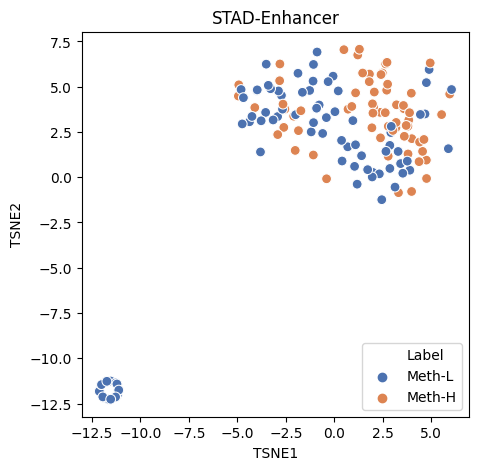

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

Region = 'Enhancer'
region_dic = {'CGI':3,'Non CGI':4, 'Promoter':5, 'Non promoter':6, 'Enhancer':7}
num = region_dic[Region]
#FEATURES = [f'{LOC}/{CANCER}/{CANCER}_EXP.csv', f'{LOC}/{CANCER}/{CANCER}_CNV.csv',
#f'{LOC}/{CANCER}/{CANCER}_MUT.csv', f'{LOC}/{CANCER}/{CANCER}_cpgisland.csv', f'{LOC}/{CANCER}/{CANCER}_non_cpgisland.csv',
#f'{LOC}/{CANCER}/{CANCER}_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_non_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_enhancer.csv']

#cpgisland =3
#non cpgisland = 4
#promoter = 5
#non promoter = 6
#enhancer = 7
# Assuming your data frame contains numeric values only, you can use the following line to convert it to a numpy array
X = feats[num].values

# Perform t-SNE with n_components=2 (to visualize in 2D) and random_state for reproducibility
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

# Add the labels to the t-SNE embedded data
df_tsne = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'])
df_tsne.index = feats[5].index
#df_tsne.index = pam50.index
df_tsne['Label'] = result_df_f['Label']

# Plot using seaborn or matplotlib (replace 'Label' with the actual column name in your labels file)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=df_tsne, palette='deep', s=50)
plt.title(CANCER+'-'+Region)
plt.legend(loc='lower right')
plt.savefig(CANCER+Region+'.pdf')
plt.show()


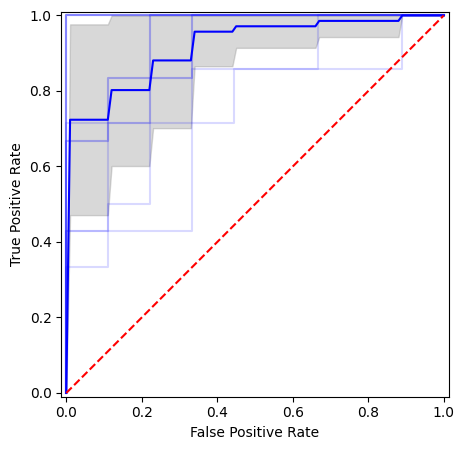

AUC scores: [0.7301587301587302, 0.8095238095238095, 1.0, 0.9365079365079365, 1.0, 0.925925925925926, 0.8703703703703705, 0.9259259259259259, 1.0, 1.0]
Mean AUC: 0.9198412698412699
Mean AUC 95% Confidence Interval: (0.85, 0.99)


In [535]:
result_df_f['Label'] = result_df_f['Sum'].apply(lambda x: 1 if x > median_value else 0)

df_meth = feats[num].reindex(result_df_f.index)
df_all = pd.concat([df_meth,result_df_f.Label],axis=1)
df_all
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from scipy import stats


# Separate features and labels
X = df_all.drop(columns=['Label'])
y = np.array(df_all['Label'])

# Standardize features
column_transformer = ColumnTransformer([('scaler', StandardScaler(), X.columns)])
X_scaled = column_transformer.fit_transform(X)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Set hyperparameters
input_size = X_scaled.shape[1]
hidden_size = 64
num_classes = len(np.unique(y))

# Initialize the model
model = MLP(input_size, hidden_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate AUC using cross-validation
auc_scores = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal', 'datalim')

for train_index, test_index in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    # Train the model
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_probs = test_outputs[:, 1].numpy()  # Assuming binary classification
        auc_score = roc_auc_score(y_test, test_probs)  # Renamed the variable to auc_score
        auc_scores.append(auc_score)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, test_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, 'b', alpha=0.15)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Test.pdf')
plt.show()

# Print the AUC scores
print("AUC scores:", auc_scores)
mean_auc = np.mean(auc_scores)
confidence = 0.95
confidence_interval = stats.sem(auc_scores) * stats.t.ppf((1 + confidence) / 2, len(auc_scores) - 1)

# Print the mean AUC and its confidence interval
print("Mean AUC:", mean_auc)
print(f"Mean AUC 95% Confidence Interval: ({mean_auc - confidence_interval:.2f}, {mean_auc + confidence_interval:.2f})")



In [99]:
ae_space_dim = 1
node_feature_num = 3 + (len(feats)-3)*ae_space_dim
sample_size = len(feats[0])
node_number = len(feats[0].columns)
feats = feats

graph = cancer_graph_list(feats, node_feature_num, sample_size, node_number)
graph.shape

(244, 192, 8)

In [141]:
graphs = []
Label = Stem
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index, dtype=torch.long),
                       edge_attr = torch.tensor(edge_attr, dtype=torch.float),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           
graphs

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3944], edge_attr=[3944, 1], y=[1]),
 Data(x=[215, 8], edge_index=[2, 3

In [140]:
def visualize_graph(graph, gene_pairs):
    vis = to_networkx(graph)
    plt.figure(1, figsize=(10, 10))
    nx.draw(vis,pos = nx.circular_layout(vis), cmap=plt.get_cmap('Set3'),node_color = '#C6442A',node_size=80, linewidths=13, labels = gene_pairs)
    plt.show()

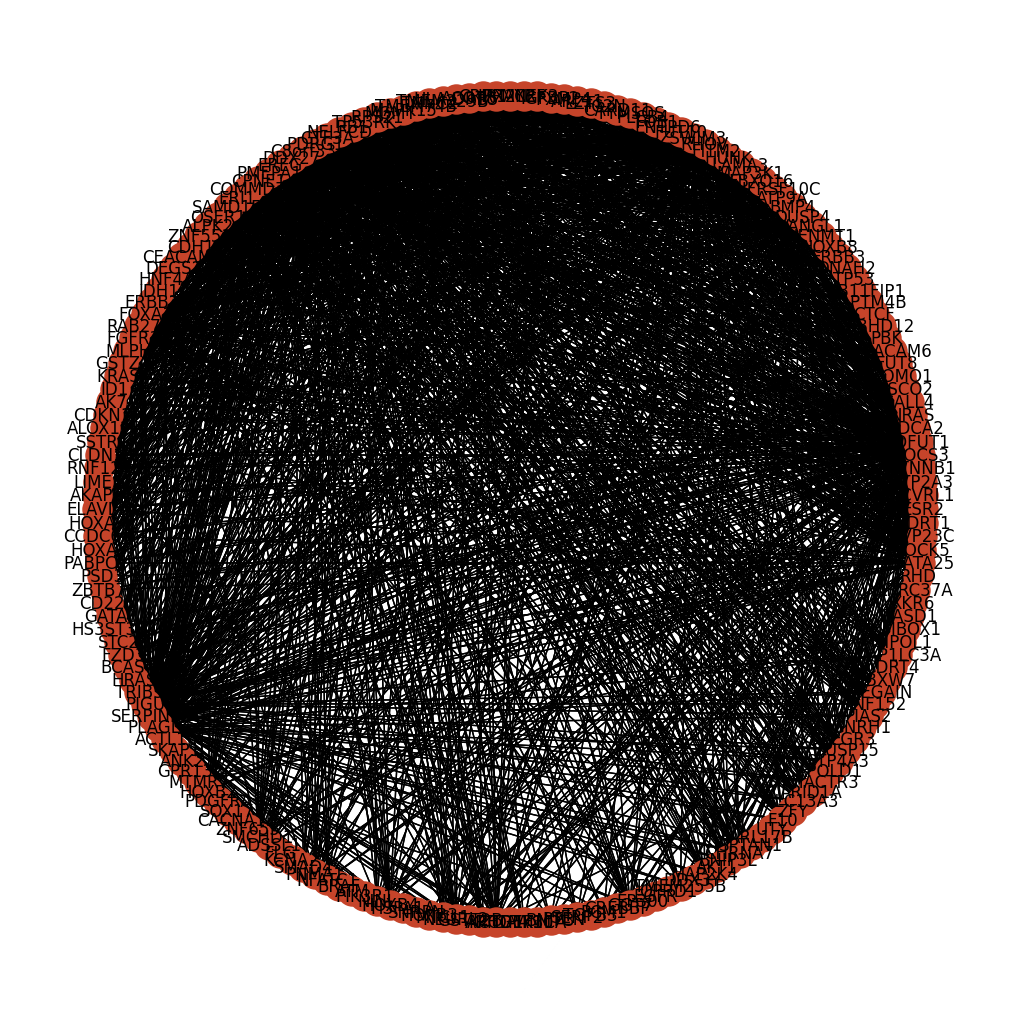

In [148]:
visualize_graph(graphs[0], gene_pairs)

In [280]:
#Only for individual feature, can skip
import copy

# Create the graph lists
graph_exp = copy.deepcopy(graphs)  # Create a deep copy of the original graph list
graph_cnv = copy.deepcopy(graphs)
graph_mut = copy.deepcopy(graphs)

# Modify the `x` attribute for each graph list
for data in graph_exp:
    data.x = data.x[:, 0]
    data.x = data.x.view(-1, 1)  # Keep only the first column

for data in graph_cnv:
    data.x = data.x[:, 1]  # Keep only the second column
    data.x = data.x.view(-1, 1)  # Keep only the first column

for data in graph_mut:
    data.x = data.x[:, 2]  # Keep only the third column
    data.x = data.x.view(-1, 1)  # Keep only the first column

In [10]:
#Graph2Dataset
from torch_geometric.data import Dataset, Data


class graph2dataset(Dataset):
    def __init__(self, graph_list):
        super(graph2dataset, self).__init__()
        self.graph_list = graph_list

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        if isinstance(index, int):
            # Single index access
            graph_data = self.graph_list[index]
        elif isinstance(index, slice):
            # Slice indexing
            graph_data = self.graph_list[index.start:index.stop:index.step]
        elif isinstance(index, list):
            # List of integers indexing
            graph_data = [self.graph_list[i] for i in index]
        else:
            raise IndexError("Invalid index type. Only integers or slices are supported.")

        if isinstance(graph_data, list):
            # If the sliced result is a list, create a new CustomGraphDataset
            return graph2dataset(graph_data)
        
        # Assuming the graph_data is in a format with attributes 'x' (node features) and 'edge_index' (edge connectivity)
        x = graph_data.x
        edge_index = graph_data.edge_index
        edge_attr = graph_data.edge_attr
        y = graph_data.y

        # Convert edge_attr to tensor if needed
        if edge_attr is not None:
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # Adjust the dtype if needed
        
        # Create a PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        
        # Set batch indices based on the number of nodes
        num_nodes = data.num_nodes

        return data


In [13]:
###GINE
from torch_geometric.nn import GINEConv, TopKPooling

batch_size = 256
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 128
edge_dim = 1


class panGINE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(panGINE, self).__init__()

        self.conv1 = GINEConv(
            nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU()
            ),edge_dim=edge_dim,
            train_eps=True
        )
        self.conv2 = GINEConv(
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU()
            ),edge_dim=edge_dim,
            train_eps=True
        )
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = gmp(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def train(dataset, writer, patience=10):
    torch.manual_seed(0000)
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)
    
    # build model
    model = panGINE(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(100):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
        
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model
      
def test(loader, model):
    model.eval()
    correct = 0.
    loss = 0.  
    for batch in loader:
        out  = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y,reduction='sum').item()
        
    return correct *1.0 / len(loader.dataset)

writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gine = graph2dataset(graphs)
model = train(dataset_gine, writer)
# Flush and close the writer
writer.flush()
writer.close()

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [253]:
###panGAT with pooling
###We have to use graph pooling instead of scatter mean 
from torch_geometric.nn import GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
import torch_scatter
from torch_geometric.nn.pool import edge_pool


batch_size = 256
lr = 0.0025
weight_decay = 5e-4
hidden_dim = 32


class panGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.convs = [GATConv(input_dim, hidden_dim, edge_dim = 1,dropout=0.6),
                      GATConv(hidden_dim, hidden_dim, edge_dim = 1,dropout=0.6)]

        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, p=0.6,training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr) # edge features here as well
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = gap(x, batch)
        x = F.log_softmax(x, dim=1)

        return x 

def train(dataset, writer, patience=5):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)
    
    # build model
    model = panGAT(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(200):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
        
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model
      
def test(loader, model):
    model.eval()
    correct = 0.
    loss = 0.  
    for batch in loader:
        out  = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y,reduction='sum').item()
        
    return correct *1.0 / len(loader.dataset)

writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gat = graph2dataset(graphs)
model = train(dataset_gat, writer)
# Flush and close the writer
writer.flush()
writer.close()


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0. Loss: 0.6895. Train accuracy: 0.5254. Test accuracy: 0.5000
Epoch 10. Loss: 0.6662. Train accuracy: 0.6441. Test accuracy: 0.6000
Epoch 20. Loss: 0.6498. Train accuracy: 0.6610. Test accuracy: 0.6000
Epoch 30. Loss: 0.6280. Train accuracy: 0.6949. Test accuracy: 0.6667
Epoch 40. Loss: 0.6409. Train accuracy: 0.6441. Test accuracy: 0.7333
Epoch 50. Loss: 0.6346. Train accuracy: 0.6525. Test accuracy: 0.6667
Epoch 60. Loss: 0.6140. Train accuracy: 0.6356. Test accuracy: 0.7000
Epoch 70. Loss: 0.6187. Train accuracy: 0.5932. Test accuracy: 0.7333
Epoch 80. Loss: 0.5972. Train accuracy: 0.6780. Test accuracy: 0.7000
Epoch 90. Loss: 0.6217. Train accuracy: 0.6695. Test accuracy: 0.8000
Epoch 100. Loss: 0.6045. Train accuracy: 0.6695. Test accuracy: 0.7000
Epoch 110. Loss: 0.6273. Train accuracy: 0.6610. Test accuracy: 0.7000
Epoch 120. Loss: 0.6502. Train accuracy: 0.6525. Test accuracy: 0.7333
Epoch 130. Loss: 0.6233. Train accuracy: 0.7288. Test accuracy: 0.7000
Epoch 140. Loss: 

In [385]:
###panGCN: for graph pooling
from torch_geometric.nn import GraphConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

batch_size = 128
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 128
        
class panGCN(nn.Module):
      def __init__(self, input_dim, hidden_dim, output_dim):
            super(panGCN, self).__init__()
            self.ratio = 0.6
            self.conv1 = GraphConv(input_dim, hidden_dim)
            self.pool1 = TopKPooling(hidden_dim, ratio = self.ratio) 
            self.conv2 = GraphConv(hidden_dim, hidden_dim)
            self.pool2 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv3 = GraphConv(hidden_dim, hidden_dim)
            self.pool3 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv4 = GraphConv(hidden_dim, hidden_dim)
            self.pool4 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.lin1 = torch.nn.Linear(hidden_dim*2, hidden_dim)   
            self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim//2)
            self.lin3 = torch.nn.Linear(hidden_dim//2, output_dim)  
      
      def forward(self, x, edge_index, edge_attr, batch):
          x = F.relu(self.conv1(x, edge_index, edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool1(x, edge_index, edge_attr, batch)
          x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv2(x, edge_index, edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool2(x, edge_index, edge_attr, batch)
          x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv3(x, edge_index, edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool3(x, edge_index, edge_attr, batch)
          x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
          x = F.relu(self.conv4(x, edge_index,edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool4(x, edge_index, edge_attr, batch)
          x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = x1 + x2 + x3 + x4

          x = F.relu(self.lin1(x))
          x = F.dropout(x, p=0.6, training=self.training)
          x = F.relu(self.lin2(x))
          x = F.log_softmax(self.lin3(x), dim=-1)

          return x
        

def train(dataset, writer, patience=10):
    torch.manual_seed(0000)
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)
    
    # build model
    model = panGCN(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(500):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
        
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model
      
def test(loader, model):
    model.eval()
    correct = 0.
    loss = 0.  
    for batch in loader:
        out  = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y,reduction='sum').item()
        
    return correct *1.0 / len(loader.dataset)

writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gcn = graph2dataset(graphs)
model = train(dataset_gcn, writer)
# Flush and close the writer
writer.flush()
writer.close()

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0. Loss: 1.3191. Train accuracy: 0.5078. Test accuracy: 0.5802


KeyboardInterrupt: 

In [85]:
##Data preparation for the combined model
LOC   = "/Users/arthurdai/Desktop/Fighting/TCGA_integrative"
CANCER = "KICH"
PPI   = f'{LOC}/{CANCER}/{CANCER}_PPI.csv'
GS = f'{LOC}/{CANCER}/{CANCER}_GS.csv'
ID = f'{LOC}/{CANCER}/{CANCER}_ID.csv'
Cluster = f'{LOC}/{CANCER}/{CANCER}_im_cluster.csv'
HRD = f'{LOC}/{CANCER}/{CANCER}_hrd.csv'
Stem = f'{LOC}/{CANCER}/{CANCER}_stem.csv'
Survival = f'{LOC}/{CANCER}/{CANCER}_survival.csv'
Stage = f'{LOC}/{CANCER}/{CANCER}_stage.csv'
FEATURES = [f'{LOC}/{CANCER}/{CANCER}_EXP.csv', f'{LOC}/{CANCER}/{CANCER}_CNV.csv',
f'{LOC}/{CANCER}/{CANCER}_MUT.csv', f'{LOC}/{CANCER}/{CANCER}_cpgisland.csv', f'{LOC}/{CANCER}/{CANCER}_non_cpgisland.csv',
f'{LOC}/{CANCER}/{CANCER}_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_non_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_enhancer.csv']


#Import multi-omics files
gs = pd.read_csv(GS, index_col=0)
#node = pd.read_csv(Node, index_col=0)
exp = pd.read_csv(FEATURES[0], index_col=0).reindex(gs.index)
id = pd.read_csv(ID, index_col=1)

Cluster = pd.read_csv(Cluster, index_col=0).reindex(id.index).Cluster
HRD = pd.read_csv(HRD, index_col=0).reindex(id.index).HRD_group
Stem = pd.read_csv(Stem, index_col=0).reindex(id.index).RNAss_group
Survival = pd.read_csv(Survival, index_col=0).reindex(id.index).OS_group
Stage = pd.read_csv(Stage, index_col=0).reindex(id.index).patho_stage

feats = []

for path in FEATURES:
      feat_df = pd.read_csv(path, index_col=0) 
      feat_df = feat_df.reindex(gs.index, fill_value=0)
      feat_df = feat_df.transpose()
      feats.append(feat_df)

#For feature 2-4
for i in range(1,3):
    feat_df = feats[i].reindex(id.index, fill_value=0)
    feats[i] = feat_df

#For feature 5-9
for i in range(3,8):
    feat_df = feats[i].reindex(id.index, fill_value=0)
    #Create list
    new_df = feat_df.applymap(split_and_convert)
    
    ls = new_df.values.tolist()
    
    for row in ls:
      lengths = [len(subset) for subset in row]
      max_length = max(lengths)
      
      # Create the VAE model
      input_dim = max_length  # Dimension of the output vector
      hidden_dim = 64  # Hidden layer dimension
      latent_dim = 16  # Latent variable dimension
      output_dim = 1
      #vae = VAE(input_dim, hidden_dim, latent_dim, output_dim)
      #ae = AE(input_dim, hidden_dim, latent_dim, output_dim)
      ael = AEL(input_dim, hidden_dim1=64, hidden_dim2=32, latent_dim=1)
    
    #Use VAE to ouput feature values
    with torch.no_grad():
        x_padded = []
        for row in new_df.values.tolist():
            padded_row = [pad_or_truncate_vector(vector, max_length) for vector in row]
            x_padded.append(padded_row)
        x = torch.tensor(x_padded, dtype=torch.float)
        torch.manual_seed(1234)
        #decoded, _, _ = vae(x)
        decoded = ael(x)
        if output_dim > 1:
         # Convert the decoded tensor to a nested list with length 3
            decoded_list = [[vector.tolist() for vector in row] for row in decoded]

        else:
            decoded_list = [[vector.tolist()[0] for vector in row] for row in decoded]


    # Convert the nested list to a DataFrame
        decoded_df = pd.DataFrame(decoded_list, columns=new_df.columns, index=new_df.index)

        feats[i] = decoded_df

exp_new = exp.transpose().reindex(id.index)
#Standardization of expression value
#columns = exp_new.columns
#exp_new[columns] = scaler.fit_transform(exp_new)

feats[0] = exp_new

#For STRING
# Read in the network  
PPI   = f'{LOC}/{CANCER}/{CANCER}_PPI.csv'  
ppi_path = PPI
ppi = pd.read_csv(ppi_path)
# old_cols are gene names
old_cols = feats[0].columns.values
    # old rows are patient names    
old_rows = feats[0].index.values
    # new_cols are ids 0:n.genes
new_cols = pd.factorize(old_cols)[0]
    # new_rows are ids 0:n.patients
new_rows = pd.factorize(old_rows)[0]

    # Mapping between genes and ids 
col_pairs = {name: no for name,no in zip(old_cols, new_cols)}
    # Mapping between patient names and ids
row_pairs = {name: no for name,no in zip(old_rows, new_rows)}

    # Harmonize/Reduce PPI with feature matrix
ppi = ppi[ppi[ppi.columns.values[0]].isin(old_cols)]
ppi = ppi[ppi[ppi.columns.values[1]].isin(old_cols)]

    #print(ppi)
    # convert genes to node ids
ppi[ppi.columns.values[0]] = ppi[ppi.columns.values[0]].map(col_pairs)
ppi[ppi.columns.values[1]] = ppi[ppi.columns.values[1]].map(col_pairs)    

gene_pairs ={value: key for key, value in col_pairs.items()}

    # col_pairs --> node ids + gene names!


edge_index = ppi[[ppi.columns.values[0], ppi.columns.values[1]]].to_numpy()
    #print(edge_index)
    # convert to a proper format and sort
edge_index = np.array(sorted(edge_index, key = lambda x: (x[0], x[1]))).T

exp_matrix = feats[0].transpose()
num_genes = len(exp_matrix)
ae_space_dim = 1
node_feature_num = 3 + (len(feats)-3)*ae_space_dim
sample_size = len(feats[0])
node_number = len(feats[0].columns)
feats = feats

graph = cancer_graph_list(feats, node_feature_num, sample_size, node_number)


In [86]:
##Set Label
from torch_geometric.utils import to_undirected
Label = Cluster
#Set Distance WGCNA threshold
threshold = 0.01

graphs_string = []
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs_string.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index, dtype=torch.long),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           

###For Distance WGCNA
correlation_matrix = pd.read_csv(f'{LOC}/{CANCER}/{CANCER}_distance_wgcna.csv', index_col=0).values

# Construct network based on correlation coefficients
G = nx.Graph()
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        correlation_coefficient = correlation_matrix[i, j]
        if correlation_coefficient > threshold:
            G.add_edge(i, j, weight=correlation_coefficient)

# Convert network to PyTorch Geometric Data object
edge_index_dw = torch.tensor(list(G.edges())).t().contiguous()
edge_attr_dw = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float).view(-1, 1)
edge_index_dw, edge_attr_dw = to_undirected(edge_index_dw, edge_attr_dw)

graphs_distance = []
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs_distance.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index_dw, dtype=torch.long),
                       edge_attr = torch.tensor(edge_attr_dw, dtype=torch.float),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))     

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [1760]:
Label
df = pd.DataFrame(Label)

# Count occurrences of 0 and 1
count_0 = (df['patho_stage'] == 0).sum()
count_1 = (df['patho_stage'] == 1).sum()

# Print the counts
print(f'Count of 0: {count_0}')
print(f'Count of 1: {count_1}')

KeyError: 'patho_stage'

In [87]:
##Combined models
from torch_geometric.nn import GraphConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

batch_size = 256
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 128

        
class panGCNS(nn.Module):
      def __init__(self, input_dim, hidden_dim, output_dim):
            super(panGCNS, self).__init__()
            self.ratio = 0.6
            self.conv1 = GraphConv(input_dim, hidden_dim)
            self.pool1 = TopKPooling(hidden_dim, ratio = self.ratio) 
            self.conv2 = GraphConv(hidden_dim, hidden_dim)
            self.pool2 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv3 = GraphConv(hidden_dim, hidden_dim)
            self.pool3 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv4 = GraphConv(hidden_dim, hidden_dim)
            self.pool4 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.lin1 = torch.nn.Linear(hidden_dim*2, hidden_dim)   
            self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim//2)
            self.lin3 = torch.nn.Linear(hidden_dim//2, output_dim)  
      
      def forward(self, x, edge_index, batch):
          x = F.relu(self.conv1(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
          x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv2(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
          x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv3(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
          x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
          x = F.relu(self.conv4(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
          x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          self.out = x1 + x2 + x3 + x4

          x = F.relu(self.lin1(self.out))
          x = F.dropout(x, p=0.6, training=self.training)
          x = F.relu(self.lin2(x))
          x = F.log_softmax(self.lin3(x), dim=-1)

          return x, self.out

class panGCND(nn.Module):
      def __init__(self, input_dim, hidden_dim, output_dim):
            super(panGCND, self).__init__()
            self.ratio = 0.6
            self.conv1 = GraphConv(input_dim, hidden_dim)
            self.pool1 = TopKPooling(hidden_dim, ratio = self.ratio) 
            self.conv2 = GraphConv(hidden_dim, hidden_dim)
            self.pool2 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv3 = GraphConv(hidden_dim, hidden_dim)
            self.pool3 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv4 = GraphConv(hidden_dim, hidden_dim)
            self.pool4 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.lin1 = torch.nn.Linear(hidden_dim*2, hidden_dim)   
            self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim//2)
            self.lin3 = torch.nn.Linear(hidden_dim//2, output_dim)  
      
      def forward(self, x, edge_index, edge_attr, batch):
          x = F.relu(self.conv1(x, edge_index, edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool1(x, edge_index, edge_attr, batch)
          x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv2(x, edge_index, edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool2(x, edge_index, edge_attr, batch)
          x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv3(x, edge_index,edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool3(x, edge_index, edge_attr, batch)
          x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
          x = F.relu(self.conv4(x, edge_index,edge_attr))
          x, edge_index, edge_attr, batch, _, _ = self.pool4(x, edge_index, edge_attr, batch)
          x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          self.out = x1 + x2 + x3 + x4

          x = F.relu(self.lin1(self.out))
          x = F.dropout(x, p=0.6, training=self.training)
          x = F.relu(self.lin2(x))
          x = F.log_softmax(self.lin3(x), dim=-1)

          return x, self.out


def train(dataset, writer, patience=10, edge_weight = None):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)
    
    # Build model based on whether edge_attr is provided
    if edge_weight is not None:
        print('Distance model')
        model = panGCND(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    else:
        print('STRING model')
        model = panGCNS(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(500):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            if edge_weight is not None:
                pred,_ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            else:
                pred,_ = model(batch.x, batch.edge_index, batch.batch)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
        
        #writer.add_scalar("loss", total_loss, epoch)
        #writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            condition=edge_weight
            test_acc = test(test_loader, model, edge_weight=condition)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            #writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model


def test(loader, model, edge_weight = None):
    model.eval()
    correct = 0.
    loss = 0.
    for batch in loader:
        if edge_weight is not None:
            out,_ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        else:
            out,_ = model(batch.x, batch.edge_index, batch.batch)
        
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y, reduction='sum').item()
        
    return correct * 1.0 / len(loader.dataset)

# Load and preprocess your datasets
dataset_gcn1 = graph2dataset(graphs_string)
dataset_gcn2 = graph2dataset(graphs_distance)

# Create models for both datasets
torch.manual_seed(0000)
writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
model_gcn1 = train(dataset_gcn1, writer, edge_weight=None)
model_gcn2 = train(dataset_gcn2, writer, edge_weight=True)
# Flush and close the writer
#writer.flush()
#writer.close()

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


STRING model
Epoch 0. Loss: 5202.5542. Train accuracy: 0.5000. Test accuracy: 0.7692
Epoch 10. Loss: 4320.4248. Train accuracy: 0.4808. Test accuracy: 0.2308
Epoch 20. Loss: 1.6957. Train accuracy: 0.5577. Test accuracy: 0.5385
Epoch 30. Loss: 0.8407. Train accuracy: 0.6154. Test accuracy: 0.4615
Epoch 40. Loss: 0.7658. Train accuracy: 0.5769. Test accuracy: 0.7692
Epoch 50. Loss: 0.6209. Train accuracy: 0.6538. Test accuracy: 0.8462
Epoch 60. Loss: 0.6818. Train accuracy: 0.6346. Test accuracy: 0.7692
Epoch 70. Loss: 0.7269. Train accuracy: 0.6154. Test accuracy: 0.7692
Epoch 80. Loss: 0.7249. Train accuracy: 0.6731. Test accuracy: 0.7692
Epoch 90. Loss: 0.7742. Train accuracy: 0.5577. Test accuracy: 0.7692
Epoch 100. Loss: 0.6697. Train accuracy: 0.5769. Test accuracy: 0.6923
Epoch 110. Loss: 0.7377. Train accuracy: 0.5192. Test accuracy: 0.7692
Epoch 120. Loss: 0.5986. Train accuracy: 0.6923. Test accuracy: 0.7692
Epoch 130. Loss: 0.6617. Train accuracy: 0.6154. Test accuracy: 0.769

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0. Loss: 1.2392. Train accuracy: 0.3077. Test accuracy: 0.2308
Epoch 10. Loss: 0.8566. Train accuracy: 0.5769. Test accuracy: 0.7692
Epoch 20. Loss: 0.7095. Train accuracy: 0.6154. Test accuracy: 0.7692
Epoch 30. Loss: 0.6309. Train accuracy: 0.6346. Test accuracy: 0.7692
Epoch 40. Loss: 0.6792. Train accuracy: 0.5192. Test accuracy: 0.7692
Epoch 50. Loss: 0.5920. Train accuracy: 0.6923. Test accuracy: 0.8462
Epoch 60. Loss: 0.4522. Train accuracy: 0.8654. Test accuracy: 0.7692
Epoch 70. Loss: 0.5418. Train accuracy: 0.7500. Test accuracy: 0.7692
Epoch 80. Loss: 0.4071. Train accuracy: 0.8462. Test accuracy: 0.9231
Epoch 90. Loss: 0.4207. Train accuracy: 0.8654. Test accuracy: 0.7692
Epoch 100. Loss: 0.3799. Train accuracy: 0.8269. Test accuracy: 0.7692
Epoch 110. Loss: 0.3302. Train accuracy: 0.8654. Test accuracy: 0.7692
Epoch 120. Loss: 0.3213. Train accuracy: 0.8654. Test accuracy: 0.7692
Epoch 130. Loss: 0.3009. Train accuracy: 0.8846. Test accuracy: 0.7692
Epoch 140. Loss: 

In [886]:
##Training for combined model
batch_size = 256
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 128
num_classes = 2

dataset_gcn1 = graph2dataset(graphs_string)
dataset_gcn2 = graph2dataset(graphs_distance)

class panSD(nn.Module):
    def __init__(self, model1, model2, num_classes):
        super(panSD, self).__init__()
        self.hidden_dim = hidden_dim  # Use the hidden_dim from either model1 or model2
        self.model1 = model1
        self.model2 = model2
        self.lin1 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        self.lin2 = torch.nn.Linear(self.hidden_dim, hidden_dim//2)
        self.lin3 = torch.nn.Linear(hidden_dim//2, num_classes)  

    def forward(self, data1, data2):
        # Get predictions from both models
        _, pred1 = self.model1(data1.x, data1.edge_index, data1.batch)
        _, pred2 = self.model2(data2.x, data2.edge_index, data2.edge_attr, data2.batch)
        
        combined_pred = pred1 + pred2
        out = self.lin1(combined_pred)
        out = F.dropout(out, p=0.6, training=self.training)  # Apply dropout
        out = self.lin2(out)
        out = F.dropout(out, p=0.6, training=self.training)  # Apply dropout again
        out = self.lin3(out)  # Pass through the additional linear layer
        final_output = F.log_softmax(out, dim=-1)  # Apply softmax

        return final_output



def train_sd(dataset1, dataset2, writer, patience=10):
    # Create a random permutation of indices for shuffling
    data_size = len(dataset1)

    train_loader1 = DataLoader(dataset1[:int(data_size * 0.8)], batch_size=batch_size, shuffle=False)
    test_loader1 = DataLoader(dataset1[int(data_size * 0.8):], batch_size=batch_size, shuffle=False)
    
    train_loader2 = DataLoader(dataset2[:int(data_size * 0.8)], batch_size=batch_size, shuffle=False)
    test_loader2 = DataLoader(dataset2[int(data_size * 0.8):], batch_size=batch_size, shuffle=False)
    
    model = panSD(model_gcn1, model_gcn2, num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(500):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch1, batch2 in zip(train_loader1, train_loader2):
            opt.zero_grad()
            pred = model(batch1, batch2)
            label = batch1.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch1.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch1.num_graphs
        
        total_loss /= len(train_loader1.dataset)
        train_acc = total_correct / total_samples
        
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            test_acc = test_sd(test_loader1, test_loader2, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model


def test_sd(loader1,loader2, model):
    model.eval()
    correct = 0.
    loss = 0.
    for batch1, batch2 in zip(loader1, loader2):
        out = model(batch1, batch2)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch1.y).sum().item()
        loss += F.nll_loss(out, batch1.y, reduction='sum').item()
        
    return correct * 1.0 / len(loader1.dataset)

torch.manual_seed(0000)
model_out = train_sd(dataset_gcn1, dataset_gcn2, writer)

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: 

In [940]:
###panSD for all metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from scipy import stats


batch_size = 256
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 128
num_classes = 2

dataset_gcn1 = graph2dataset(graphs_string)
dataset_gcn2 = graph2dataset(graphs_distance)

def train_sd(dataset1, dataset2, writer, patience=10, num_folds=5):
    data_size = len(dataset1)
    
    # Initialize lists to store metrics and best metrics for each fold
    all_fold_metrics = []
    best_fold_metrics = []
    
    # Create a random permutation of indices for shuffling
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    y_values = []

    for graph in dataset1:
        y_values.append(graph.y.item()) 

    for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(data_size), y_values)):
        train_index = list(train_index)  # Convert train_index to a list
        test_index = list(test_index)
        train_loader1 = DataLoader(dataset1[train_index], batch_size=batch_size, shuffle=False)
        test_loader1 = DataLoader(dataset1[test_index], batch_size=batch_size, shuffle=False)
        
        train_loader2 = DataLoader(dataset2[train_index], batch_size=batch_size, shuffle=False)
        test_loader2 = DataLoader(dataset2[test_index], batch_size=batch_size, shuffle=False)

        model = panSD(model_gcn1, model_gcn2, num_classes)
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_metrics = {
            'test_accuracy': 0.0,
            'precision': 0.0,
            'f1_score': 0.0,
            'mcc': 0.0,
            'auc': 0.0
        }

        for epoch in range(500):
            total_loss = 0
            total_correct = 0
            total_samples = 0
            model.train()

            for batch1, batch2 in zip(train_loader1, train_loader2):
                opt.zero_grad()
                pred = model(batch1, batch2)
                label = batch1.y
                loss = F.nll_loss(pred, label)
                loss.backward()
                total_loss += batch1.num_graphs * loss.item()
                opt.step()

                pred_labels = pred.argmax(dim=1)
                correct = pred_labels.eq(label).sum().item()
                total_correct += correct
                total_samples += batch1.num_graphs

            total_loss /= len(train_loader1.dataset)
            train_acc = total_correct / total_samples

            writer.add_scalar("loss", total_loss, epoch)
            writer.add_scalar("train accuracy", train_acc, epoch)

            if epoch % 10 == 0:
                test_acc, precision, f1, mcc, auc = test_sd(test_loader1, test_loader2, model)
                print("Fold {}, Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}. "
                      "Precision: {:.4f}. F1 Score: {:.4f}. MCC: {:.4f}. AUC: {:.4f}".format(
                    fold, epoch, total_loss, train_acc, test_acc, precision, f1, mcc, auc))

                writer.add_scalar("test accuracy", test_acc, epoch)

                # Check if the current model's test accuracy is the best
                if test_acc > best_metrics['test_accuracy']:
                    best_metrics['test_accuracy'] = test_acc
                    best_metrics['precision'] = precision
                    best_metrics['f1_score'] = f1
                    best_metrics['mcc'] = mcc
                    best_metrics['auc'] = auc

                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

                if early_stopping_counter >= patience:
                    print("Early stopping at epoch", epoch)
                    break  # Stop training
        
        # Store metrics for this fold
        all_fold_metrics.append(best_metrics)
        
        # Store best metrics for this fold
        best_fold_metrics.append(best_metrics)

    return all_fold_metrics, best_fold_metrics

def calculate_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def test_sd(loader1, loader2, model):
    model.eval()
    correct = 0.
    loss = 0.
    all_labels = []
    all_preds = []
    
    for batch1, batch2 in zip(loader1, loader2):
        out = model(batch1, batch2)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch1.y).sum().item()
        loss += F.nll_loss(out, batch1.y, reduction='sum').item()
        
        all_labels.extend(batch1.y.tolist())
        all_preds.extend(pred.tolist())
        
    test_acc = correct * 1.0 / len(loader1.dataset)
    precision = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    
    # Calculate AUC score
    all_preds_proba = F.softmax(out, dim=1).detach().cpu().numpy()
    auc = roc_auc_score(all_labels, all_preds_proba[:, 1])  # Assuming binary classification
    
    return test_acc, precision, f1, mcc, auc

torch.manual_seed(0000)
# After training is done, calculate metrics and confidence intervals
all_fold_metrics = train_sd(dataset_gcn1, dataset_gcn2, writer)
# Calculate mean and confidence intervals for each metric
best_fold_metrics = list(all_fold_metrics)[1]
metric_names = ['test_accuracy', 'precision', 'f1_score', 'mcc', 'auc']
for metric_name in metric_names:
    metric_values = [fold_metrics[metric_name] for fold_metrics in best_fold_metrics]
    mean_metric, ci_metric = calculate_confidence_interval(metric_values)

    print(f"{metric_name}: {mean_metric:.4f} (± {ci_metric:.4f})")

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Fold 0, Epoch 0. Loss: 0.6781. Train accuracy: 0.6604. Test accuracy: 0.7550. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.4674


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 10. Loss: 0.5697. Train accuracy: 0.7481. Test accuracy: 0.7550. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.4528


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 20. Loss: 0.5759. Train accuracy: 0.7506. Test accuracy: 0.7550. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.4634
Fold 0, Epoch 30. Loss: 0.5684. Train accuracy: 0.7494. Test accuracy: 0.7550. Precision: 0.5000. F1 Score: 0.0392. MCC: 0.0596. AUC: 0.4945


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 40. Loss: 0.5526. Train accuracy: 0.7519. Test accuracy: 0.7550. Precision: 0.5000. F1 Score: 0.0392. MCC: 0.0596. AUC: 0.4864


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 50. Loss: 0.5559. Train accuracy: 0.7556. Test accuracy: 0.7500. Precision: 0.4000. F1 Score: 0.0741. MCC: 0.0577. AUC: 0.4906


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 60. Loss: 0.5531. Train accuracy: 0.7356. Test accuracy: 0.7350. Precision: 0.1667. F1 Score: 0.0364. MCC: -0.0320. AUC: 0.4645


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 70. Loss: 0.5441. Train accuracy: 0.7494. Test accuracy: 0.7250. Precision: 0.1250. F1 Score: 0.0351. MCC: -0.0570. AUC: 0.4399


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 80. Loss: 0.5293. Train accuracy: 0.7569. Test accuracy: 0.7350. Precision: 0.3000. F1 Score: 0.1017. MCC: 0.0293. AUC: 0.4740


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 90. Loss: 0.5281. Train accuracy: 0.7506. Test accuracy: 0.6800. Precision: 0.2000. F1 Score: 0.1351. MCC: -0.0395. AUC: 0.4741


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 0, Epoch 100. Loss: 0.5253. Train accuracy: 0.7632. Test accuracy: 0.7100. Precision: 0.3333. F1 Score: 0.2368. MCC: 0.0811. AUC: 0.5125
Early stopping at epoch 100


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Fold 1, Epoch 0. Loss: 0.6489. Train accuracy: 0.6140. Test accuracy: 0.7500. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.5868


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 10. Loss: 0.5449. Train accuracy: 0.7556. Test accuracy: 0.7500. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.6500
Fold 1, Epoch 20. Loss: 0.5451. Train accuracy: 0.7368. Test accuracy: 0.7650. Precision: 1.0000. F1 Score: 0.1132. MCC: 0.2137. AUC: 0.6291


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 30. Loss: 0.5315. Train accuracy: 0.7469. Test accuracy: 0.7550. Precision: 0.5714. F1 Score: 0.1404. MCC: 0.1414. AUC: 0.6360


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 40. Loss: 0.5123. Train accuracy: 0.7393. Test accuracy: 0.7550. Precision: 0.5714. F1 Score: 0.1404. MCC: 0.1414. AUC: 0.6053


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 50. Loss: 0.5032. Train accuracy: 0.7444. Test accuracy: 0.7550. Precision: 0.5714. F1 Score: 0.1404. MCC: 0.1414. AUC: 0.5956


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 60. Loss: 0.5109. Train accuracy: 0.7456. Test accuracy: 0.7350. Precision: 0.4118. F1 Score: 0.2090. MCC: 0.1139. AUC: 0.5905


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 70. Loss: 0.5219. Train accuracy: 0.7343. Test accuracy: 0.7450. Precision: 0.4545. F1 Score: 0.1639. MCC: 0.1140. AUC: 0.6635


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 80. Loss: 0.5165. Train accuracy: 0.7506. Test accuracy: 0.7150. Precision: 0.3939. F1 Score: 0.3133. MCC: 0.1478. AUC: 0.6387


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 90. Loss: 0.4889. Train accuracy: 0.7419. Test accuracy: 0.7250. Precision: 0.3684. F1 Score: 0.2029. MCC: 0.0886. AUC: 0.6412


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 100. Loss: 0.5078. Train accuracy: 0.7669. Test accuracy: 0.7450. Precision: 0.4762. F1 Score: 0.2817. MCC: 0.1789. AUC: 0.5836


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 110. Loss: 0.4646. Train accuracy: 0.7707. Test accuracy: 0.6850. Precision: 0.3333. F1 Score: 0.2921. MCC: 0.0947. AUC: 0.5965


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 1, Epoch 120. Loss: 0.4366. Train accuracy: 0.7807. Test accuracy: 0.7100. Precision: 0.3667. F1 Score: 0.2750. MCC: 0.1132. AUC: 0.6371
Early stopping at epoch 120


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Fold 2, Epoch 0. Loss: 0.6545. Train accuracy: 0.6466. Test accuracy: 0.7500. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.6239


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 10. Loss: 0.5452. Train accuracy: 0.7494. Test accuracy: 0.7500. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.6893
Fold 2, Epoch 20. Loss: 0.5209. Train accuracy: 0.7481. Test accuracy: 0.7450. Precision: 0.4667. F1 Score: 0.2154. MCC: 0.1425. AUC: 0.6883


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 30. Loss: 0.4988. Train accuracy: 0.7556. Test accuracy: 0.7650. Precision: 0.5882. F1 Score: 0.2985. MCC: 0.2381. AUC: 0.7107


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 40. Loss: 0.4996. Train accuracy: 0.7581. Test accuracy: 0.7350. Precision: 0.4211. F1 Score: 0.2319. MCC: 0.1280. AUC: 0.7173


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 50. Loss: 0.4812. Train accuracy: 0.7306. Test accuracy: 0.7400. Precision: 0.4167. F1 Score: 0.1613. MCC: 0.0972. AUC: 0.7129


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 60. Loss: 0.4669. Train accuracy: 0.7431. Test accuracy: 0.7550. Precision: 0.5238. F1 Score: 0.3099. MCC: 0.2166. AUC: 0.7160


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 70. Loss: 0.4660. Train accuracy: 0.7807. Test accuracy: 0.7550. Precision: 0.5152. F1 Score: 0.4096. MCC: 0.2722. AUC: 0.6993


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 80. Loss: 0.4458. Train accuracy: 0.7669. Test accuracy: 0.7400. Precision: 0.4615. F1 Score: 0.3158. MCC: 0.1888. AUC: 0.7107


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 90. Loss: 0.4303. Train accuracy: 0.7782. Test accuracy: 0.7550. Precision: 0.5128. F1 Score: 0.4494. MCC: 0.2987. AUC: 0.7179


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 100. Loss: 0.4408. Train accuracy: 0.7707. Test accuracy: 0.7450. Precision: 0.4857. F1 Score: 0.4000. MCC: 0.2507. AUC: 0.6812


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 110. Loss: 0.4480. Train accuracy: 0.7682. Test accuracy: 0.7300. Precision: 0.4091. F1 Score: 0.2500. MCC: 0.1292. AUC: 0.7076


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 120. Loss: 0.4392. Train accuracy: 0.7757. Test accuracy: 0.7500. Precision: 0.5000. F1 Score: 0.3421. MCC: 0.2232. AUC: 0.6812


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 2, Epoch 130. Loss: 0.4462. Train accuracy: 0.7669. Test accuracy: 0.7100. Precision: 0.3947. F1 Score: 0.3409. MCC: 0.1619. AUC: 0.6960
Early stopping at epoch 130


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Fold 3, Epoch 0. Loss: 0.6405. Train accuracy: 0.6496. Test accuracy: 0.7538. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.6303
Fold 3, Epoch 10. Loss: 0.5013. Train accuracy: 0.7635. Test accuracy: 0.7739. Precision: 0.8333. F1 Score: 0.1818. MCC: 0.2403. AUC: 0.7204


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 20. Loss: 0.4928. Train accuracy: 0.7334. Test accuracy: 0.7538. Precision: 0.5000. F1 Score: 0.1404. MCC: 0.1206. AUC: 0.7189


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 30. Loss: 0.4949. Train accuracy: 0.7409. Test accuracy: 0.7638. Precision: 0.5455. F1 Score: 0.3380. MCC: 0.2449. AUC: 0.6986


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 40. Loss: 0.4614. Train accuracy: 0.7697. Test accuracy: 0.7387. Precision: 0.4571. F1 Score: 0.3810. MCC: 0.2262. AUC: 0.7279


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 50. Loss: 0.4633. Train accuracy: 0.7610. Test accuracy: 0.7688. Precision: 0.5714. F1 Score: 0.3429. MCC: 0.2593. AUC: 0.7363


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 60. Loss: 0.4617. Train accuracy: 0.7622. Test accuracy: 0.7487. Precision: 0.4828. F1 Score: 0.3590. MCC: 0.2268. AUC: 0.7252


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 70. Loss: 0.4465. Train accuracy: 0.7785. Test accuracy: 0.7437. Precision: 0.4722. F1 Score: 0.4000. MCC: 0.2465. AUC: 0.7278


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 80. Loss: 0.4258. Train accuracy: 0.7960. Test accuracy: 0.7337. Precision: 0.4333. F1 Score: 0.3291. MCC: 0.1830. AUC: 0.7339


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 90. Loss: 0.4860. Train accuracy: 0.7509. Test accuracy: 0.7337. Precision: 0.4231. F1 Score: 0.2933. MCC: 0.1591. AUC: 0.6943


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 100. Loss: 0.4173. Train accuracy: 0.7672. Test accuracy: 0.7337. Precision: 0.4412. F1 Score: 0.3614. MCC: 0.2054. AUC: 0.7279


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 3, Epoch 110. Loss: 0.4335. Train accuracy: 0.7584. Test accuracy: 0.7387. Precision: 0.3846. F1 Score: 0.1613. MCC: 0.0849. AUC: 0.7056
Early stopping at epoch 110


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

Fold 4, Epoch 0. Loss: 0.5988. Train accuracy: 0.6946. Test accuracy: 0.7538. Precision: 0.0000. F1 Score: 0.0000. MCC: 0.0000. AUC: 0.6663
Fold 4, Epoch 10. Loss: 0.4625. Train accuracy: 0.7334. Test accuracy: 0.7638. Precision: 0.5455. F1 Score: 0.3380. MCC: 0.2449. AUC: 0.7102


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 20. Loss: 0.4722. Train accuracy: 0.7622. Test accuracy: 0.7889. Precision: 0.6207. F1 Score: 0.4615. MCC: 0.3590. AUC: 0.6849


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 30. Loss: 0.4163. Train accuracy: 0.7997. Test accuracy: 0.7387. Precision: 0.4571. F1 Score: 0.3810. MCC: 0.2262. AUC: 0.6804


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 40. Loss: 0.4074. Train accuracy: 0.7847. Test accuracy: 0.7538. Precision: 0.5000. F1 Score: 0.3288. MCC: 0.2181. AUC: 0.6808


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 50. Loss: 0.3963. Train accuracy: 0.7922. Test accuracy: 0.7186. Precision: 0.4103. F1 Score: 0.3636. MCC: 0.1880. AUC: 0.6656


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 60. Loss: 0.4173. Train accuracy: 0.7897. Test accuracy: 0.7236. Precision: 0.4118. F1 Score: 0.3373. MCC: 0.1744. AUC: 0.6767


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 70. Loss: 0.4547. Train accuracy: 0.7685. Test accuracy: 0.7487. Precision: 0.4865. F1 Score: 0.4186. MCC: 0.2665. AUC: 0.7278


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 80. Loss: 0.4067. Train accuracy: 0.7972. Test accuracy: 0.6985. Precision: 0.3721. F1 Score: 0.3478. MCC: 0.1534. AUC: 0.6903


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 90. Loss: 0.4393. Train accuracy: 0.7697. Test accuracy: 0.6935. Precision: 0.3421. F1 Score: 0.2989. MCC: 0.1081. AUC: 0.6792


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 100. Loss: 0.3704. Train accuracy: 0.8235. Test accuracy: 0.6935. Precision: 0.3750. F1 Score: 0.3711. MCC: 0.1685. AUC: 0.6667


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 110. Loss: 0.3562. Train accuracy: 0.8335. Test accuracy: 0.7136. Precision: 0.4167. F1 Score: 0.4124. MCC: 0.2230. AUC: 0.6841


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold 4, Epoch 120. Loss: 0.3662. Train accuracy: 0.8160. Test accuracy: 0.7136. Precision: 0.4167. F1 Score: 0.4124. MCC: 0.2230. AUC: 0.6680
Early stopping at epoch 120
test_accuracy: 0.7696 (± 0.0158)
precision: 0.6085 (± 0.4706)
f1_score: 0.2110 (± 0.2198)
mcc: 0.2102 (± 0.1619)
auc: 0.6425 (± 0.1293)


In [263]:
#For mode ROC
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dataset = graph2dataset(graphs)
data_size = len(dataset)
# Create a function to plot ROC curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Assuming you have already trained your model using the provided training code

# Initialize the model
model = panGCN(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)  # Replace with your actual values
model.eval()  # Set the model to evaluation mode

# Initialize data loader for test dataset
test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate through the test dataset
for batch in test_loader:
    # Forward pass through the model
    out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
    probs = out.softmax(dim=1)[:, 1]  # Probability of positive class (assuming binary classification)
    
    # Collect true labels and predicted probabilities
    true_labels.extend(batch.y.tolist())
    predicted_probs.extend(probs.tolist())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Plot ROC curve
plot_roc_curve(true_labels, predicted_probs, title='ROC Curve for panGCN Model')

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


TypeError: forward() takes 4 positional arguments but 5 were given

In [244]:
#For hyperparameter fine tuning
from hyperopt import hp, fmin, tpe
from ray import tune

# Define your dataset and loaders here
dataset = graph2dataset(graphs)
data_size = len(dataset)
loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)

space = {
    'hidden_dim': hp.quniform('hidden_dim', 32, 64, 1),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1e-3)),
    # ... define other hyperparameters and their search spaces
}

def hyperopt_objective(params):
    # Extract hyperparameters from the input dictionary
    hidden_dim = int(params['hidden_dim'])
    lr = params['lr']
    weight_decay = params['weight_decay']

    # Build the panGCN model
    model = panGAT(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train and evaluate the GNN model with the given hyperparameters
    for epoch in range(20):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            optimizer.step()

    accuracy = test(test_loader, model)
    
    # Hyperopt aims to minimize the objective, so return the negative accuracy
    return -accuracy

# Run Hyperopt optimization
best_hyperparams = fmin(fn=hyperopt_objective, space=space, algo=tpe.suggest, max_evals=100)



2023-08-18 14:47:00,871	INFO util.py:125 -- Outdated packages:
  ipywidgets==7.5.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-08-18 14:47:01,370	INFO util.py:125 -- Outdated packages:
  ipywidgets==7.5.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



100%|██████████| 100/100 [31:51<00:00, 19.12s/trial, best loss: -0.8]              


In [993]:
###This chunk is created for graph prediction, extracted from Github examples
from torch_geometric.nn import MessagePassing
# Solution

def graph_loss(
    x: torch.tensor,                     
    edge_index: torch.tensor,
    edge_attr: torch.tensor,
    batch_index: torch.tensor,
    node_feat_mask: torch.nn.Parameter, 
    edge_mask: torch.nn.Parameter,      
    expl_label: int,
    model) -> torch.tensor:
    """
    Computes the explainer loss function for explanation
    of graph classificaiton tasks.

    Args:
        x : torch.Tensor
            Feature matrix of datapoint to explain.
        edge_index : torch.LongTensor
            A Tensor that defines the underlying graph connectivity/message
            passing flow. `edge_index` holds the indices of a general (sparse)
            assignment matrix of shape `[N, M]`. Its shape must be defined as
            `[2, num_messages]`, where messages from nodes in `edge_index[0]`
            are sent to nodes in `edge_index[1]`.
        batch_index : torch.LongTensor
            Column vector which maps each node to its respective graph in the batch.
        node_feat_mask : torch.nn.Parameter
            representing node feature mask of size [n_features]
        edge_mask : torch.nn.Parameter
            representing edge mask of size [n_edges]
        expl_label : int
            Label with respect to which we want the explanation.
        model : nn.Module
            a (pretrained) model
    Returns:
        loss (torch.tensor): explainer loss function, which
            is a weight sum of different terms.
    """
    EPS = 1e-15

    # Apply sigmoid to masks
    edge_mask = edge_mask.sigmoid()
    node_feat_mask = node_feat_mask.sigmoid()

    # Loss terms weights
    coeffs = {"edge_size":0.01,
            "node_feat_size":0.07,
            "edge_entropy":1.0}

    # Mask node features
    h = x * node_feat_mask

    # Mask edges: instead of applying the mask on edge_index, make the model
    # aware of the mask
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.__explain__ = True
            module.__edge_mask__ = edge_mask

    # Compute model output (we assume the model already gives log probabilities)
    model_pred_log_proba = model(h, edge_index, edge_attr, batch_index)

    # Prediction loss.
    pred_loss = -model_pred_log_proba[:, expl_label]

    # Edge mask size loss.
    edge_mask_size_loss = edge_mask.sum()

    # Edge mask entropy loss.
    ent_loss = (-edge_mask * torch.log(edge_mask + EPS) -
                (1 - edge_mask) * torch.log(1 - edge_mask + EPS)).mean()

    # Feature mask size loss.
    feat_mask_size_loss = node_feat_mask.sum()

    # Sum all loss terms
    loss = pred_loss + \
           coeffs['edge_size'] * edge_mask_size_loss + \
           coeffs['edge_entropy'] *ent_loss + \
           coeffs['node_feat_size'] * feat_mask_size_loss

    return loss.sum()

In [994]:
###This chunk is created for graph prediction, extracted from Github examples

import math
from copy import deepcopy

dataset = dataset_gcn1
data_size = len(dataset)
loader = DataLoader(dataset, batch_size=32,shuffle=True)

data_batch = next(iter(loader))

x = data_batch.x
edge_index = data_batch.edge_index
batch_index = data_batch.batch
edge_attr = data_batch.edge_attr

(nodes, feat), edges = x.size(), edge_index.size(1)

# Feat mask
node_feat_mask = torch.nn.Parameter(torch.randn(feat) * 0.1)

# Edge mask.
edge_mask = torch.nn.Parameter(torch.randn(edges) * 0.1)

expl_label = 1

loss = graph_loss(x,                     
    edge_index,
    edge_attr,
    batch_index,
    node_feat_mask, 
    edge_mask,      
    expl_label,
    deepcopy(model))

print(f"Computed loss : {round(loss.item(), 2)}")

Computed loss : 6354068.5


In [17]:
###This chunk is created for graph prediction, extracted from Github examples
from src import GNNExplainer
#from src import plot_mol
from src import make_interactive_explainer, explain_graph_visualized

In [19]:
#Explainer1
"""Module implementing GNNExplainer class Modified by YHD"""
from math import sqrt

import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.explain.config import MaskType, ModelMode, ModelTaskLevel

EPS = 1e-15

################################################################################
# EXPLAINER


class GNNExplainer1(torch.nn.Module):
    """The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s graph-prediction.
    """
    def __init__(
        self,
        model,
        epochs=100,
        lr=0.04,
        edge_size=0.01,
        edge_ent=1.0,
        node_feat_size=0.07,
        node_feat_ent=0.1,
    ):
        """ Initialize GNNExplainer Class.

        Args:
            model (torch.nn.Module): A (pretrained) GNN module to explain.
            epochs (int, optional): The number of epochs to train.
                (default: :obj:`100`)
            lr (float, optional): The learning rate to apply.
                (default: :obj:`0.04`)
        """
        super(GNNExplainer1, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.coeffs = dict(
            edge_size=edge_size,
            node_feat_size=node_feat_size,
            edge_ent=edge_ent,
            node_feat_ent=node_feat_ent,
        )

    def __set_masks__(self, x, edge_index):
        """ Initialize the masks for edges and node features.

        For each module contained in the GNN model, the attribute
        __edge_mask__ is set to the initialized edge mask, so that
        it is handled in message passing by pytorch geometric.

        Args:
            x (torch tensor): node features
            edge_index (torch tensor): pytorch geometric edge index
        """
        (N, F), E = x.size(), edge_index.size(1)

        # Node feature mask.
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        # Edge mask.
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        """Deletes the node and edge masks.
        """
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    def graph_loss(self, x: torch.Tensor, edge_index: torch.LongTensor,
                   batch_index: torch.LongTensor, expl_label: int,
                   **kwargs) -> torch.Tensor:
        """Computes the explainer loss function for explanation
        of graph classificaiton tasks.

        Args:
            x : torch.Tensor
                Feature matrix of datapoint to explain.
            edge_index : torch.LongTensor
                A Tensor that defines the underlying graph connectivity/message
                passing flow. `edge_index` holds the indices of a general (sparse)
                assignment matrix of shape `[N, M]`. Its shape must be defined as
                `[2, num_messages]`, where messages from nodes in `edge_index[0]`
                are sent to nodes in `edge_index[1]`.
            batch_index : torch.LongTensor
                Column vector which maps each node to its respective graph in the batch.
            expl_label : int
                Label with respect to which we want the explanation.
            **kwargs : optional
                Additional keyword arguments to be passed to the GNN model.

        Returns:
            torch.Tensor
                explainer loss function, which is a weighted sum of different terms.
        """
        # Mask node features
        h = x * self.node_feat_mask.view(1, -1).sigmoid()

        # Compute model output (we assume the model already gives log probabilities)
        model_pred_log_proba,_ = self.model(h, edge_index, batch_index, **kwargs)
        # Prediction loss.
        loss = -model_pred_log_proba[:, expl_label]

        # Edge mask size loss.
        edge_mask = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * edge_mask.sum()

        # Edge mask entropy loss.
        ent = -edge_mask * torch.log(edge_mask + EPS) - (
            1 - edge_mask) * torch.log(1 - edge_mask + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        # Feature mask size loss.
        feat_mask = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * feat_mask.mean()

        return loss.sum()

    def explain_graph(self, x, edge_index, batch_index, expl_label: int,
                      **kwargs) -> (torch.nn.Parameter, torch.nn.Parameter):
        """Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for graph
        classification.

        Args:
            x : Tensor
                The node feature matrix.
            edge_index : torch.LongTensor
                A Tensor that defines the underlying graph connectivity/message passing flow.
            batch_index : torch.LongTensor
                Column vector which maps each node to its respective graph in the batch.
            expl_label : int
                Label with respect to which we want the explanation.
            **kwargs : optional
                Additional keyword arguments to be passed to the GNN model.

        Returns:
            torch.Tensor, torch.Tensor
                The node feature mask and edge mask
        """

        self.model.eval()
        self.__clear_masks__()

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        for epoch in range(self.epochs):
            optimizer.zero_grad()

            loss = self.graph_loss(x, edge_index, batch_index, expl_label,
                                   **kwargs)
            loss.backward()

            optimizer.step()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask

In [20]:
#Explainer2
"""Module implementing GNNExplainer class Modified by YHD"""
from math import sqrt

import torch
from torch_geometric.nn import MessagePassing

EPS = 1e-15

################################################################################
# EXPLAINER
class GNNExplainer2(torch.nn.Module):
    """The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s graph-prediction.
    """
    def __init__(
        self,
        model,
        epochs=100,
        lr=0.04,
        edge_size=0.01,
        edge_ent=1.0,
        node_feat_size=0.07,
        node_feat_ent=0.1,
    ):
        """ Initialize GNNExplainer Class.

        Args:
            model (torch.nn.Module): A (pretrained) GNN module to explain.
            epochs (int, optional): The number of epochs to train.
                (default: :obj:`100`)
            lr (float, optional): The learning rate to apply.
                (default: :obj:`0.04`)
        """
        super(GNNExplainer2, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.coeffs = dict(
            edge_size=edge_size,
            node_feat_size=node_feat_size,
            edge_ent=edge_ent,
            node_feat_ent=node_feat_ent,
        )

    def __set_masks__(self, x, edge_index):
        """ Initialize the masks for edges and node features.

        For each module contained in the GNN model, the attribute
        __edge_mask__ is set to the initialized edge mask, so that
        it is handled in message passing by pytorch geometric.

        Args:
            x (torch tensor): node features
            edge_index (torch tensor): pytorch geometric edge index
        """
        (N, F), E = x.size(), edge_index.size(1)

        # Node feature mask.
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        # Edge mask.
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        """Deletes the node and edge masks.
        """
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    def graph_loss(self, x: torch.Tensor, edge_index: torch.LongTensor,edge_attr: torch.Tensor,
                   batch_index: torch.LongTensor, expl_label: int,
                   **kwargs) -> torch.Tensor:
        """Computes the explainer loss function for explanation
        of graph classificaiton tasks.

        Args:
            x : torch.Tensor
                Feature matrix of datapoint to explain.
            edge_index : torch.LongTensor
                A Tensor that defines the underlying graph connectivity/message
                passing flow. `edge_index` holds the indices of a general (sparse)
                assignment matrix of shape `[N, M]`. Its shape must be defined as
                `[2, num_messages]`, where messages from nodes in `edge_index[0]`
                are sent to nodes in `edge_index[1]`.
            batch_index : torch.LongTensor
                Column vector which maps each node to its respective graph in the batch.
            expl_label : int
                Label with respect to which we want the explanation.
            **kwargs : optional
                Additional keyword arguments to be passed to the GNN model.

        Returns:
            torch.Tensor
                explainer loss function, which is a weighted sum of different terms.
        """
        # Mask node features
        h = x * self.node_feat_mask.view(1, -1).sigmoid()

        # Compute model output (we assume the model already gives log probabilities)
        model_pred_log_proba,_ = self.model(h, edge_index, edge_attr, batch_index, **kwargs)

        # Prediction loss.
        loss = -model_pred_log_proba[:, expl_label]

        # Edge mask size loss.
        edge_mask = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * edge_mask.sum()

        # Edge mask entropy loss.
        ent = -edge_mask * torch.log(edge_mask + EPS) - (
            1 - edge_mask) * torch.log(1 - edge_mask + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        # Feature mask size loss.
        feat_mask = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * feat_mask.mean()

        return loss.sum()

    def explain_graph(self, x, edge_index, edge_attr, batch_index, expl_label: int,
                      **kwargs) -> (torch.nn.Parameter, torch.nn.Parameter):
        """Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for graph
        classification.

        Args:
            x : Tensor
                The node feature matrix.
            edge_index : torch.LongTensor
                A Tensor that defines the underlying graph connectivity/message passing flow.
            batch_index : torch.LongTensor
                Column vector which maps each node to its respective graph in the batch.
            expl_label : int
                Label with respect to which we want the explanation.
            **kwargs : optional
                Additional keyword arguments to be passed to the GNN model.

        Returns:
            torch.Tensor, torch.Tensor
                The node feature mask and edge mask
        """

        self.model.eval()
        self.__clear_masks__()

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        for epoch in range(self.epochs):
            optimizer.zero_grad()

            loss = self.graph_loss(x, edge_index, edge_attr, batch_index, expl_label,
                                   **kwargs)
            loss.backward()

            optimizer.step()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask


In [876]:
#For symbol labeling
gene_symbols = []
for keys, values in gene_pairs.items():
    gene_symbols.append(values)
gene_symbols = pd.Series(data = gene_symbols)

class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __init__(self, gene_symbols):
        self.gene_symbols = gene_symbols

    def __call__(self, data):
        data.symbols = self.gene_symbols
        return data

dataset = dataset_gcn
transform = AddSymbols(gene_symbols.values)
dataset_t = [transform(data) for data in dataset]


In [88]:
###This chunk is created for graph prediction, extracted from Github examples

#####For STRING network####

edge_num1 = graphs_string[0].num_edges 
feat_mask_temp1 = np.zeros(8)
edge_mask_temp1 = np.zeros(edge_num1)

#Compute cumulative node and edge importance througout dataset
for data in dataset_gcn1:
    explainer = GNNExplainer1(model_gcn1, epochs=100, lr = 0.01)
    # Train explainer
    model_args = (
    data.x,
    data.edge_index,
    torch.zeros(data.num_nodes, dtype=int))
    
    GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
    *model_args,
    model_gcn1(*model_args)[0].argmax(dim=1))

    # Convert the PyTorch tensors to numpy arrays
    feat_mask = GNNExp_feat_mask.detach().cpu().numpy()
    edge_mask = GNNExp_edge_mask.detach().cpu().numpy()
    

    feat_mask_temp1+=feat_mask
    edge_mask_temp1+=edge_mask

#####For distance network####

edge_num2 = graphs_distance[0].num_edges
feat_mask_temp2 = np.zeros(8)
edge_mask_temp2 = np.zeros(edge_num2)

#Compute cumulative node and edge importance througout dataset
for data in dataset_gcn2:
    explainer = GNNExplainer2(model_gcn2, epochs=100, lr = 0.01)
    # Train explainer
    model_args = (
    data.x,
    data.edge_index,
    data.edge_attr,
    torch.zeros(data.num_nodes, dtype=int))
    
    GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
    *model_args,
    model_gcn2(*model_args)[0].argmax(dim=1))

    # Convert the PyTorch tensors to numpy arrays
    feat_mask = GNNExp_feat_mask.detach().cpu().numpy()
    edge_mask = GNNExp_edge_mask.detach().cpu().numpy()
    

    feat_mask_temp2+=feat_mask
    edge_mask_temp2+=edge_mask

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


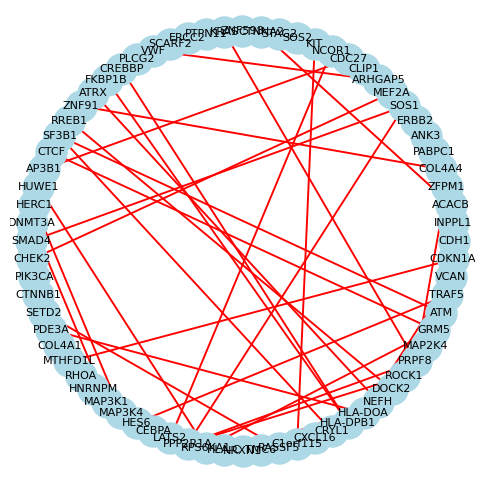

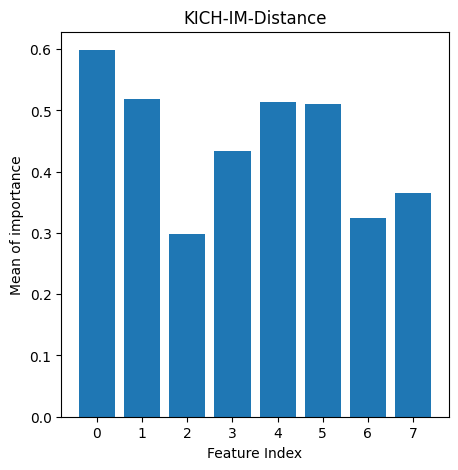

Most Important Edge: (2, 17)
Connected Nodes: ACACB CTNNA2


In [91]:
import matplotlib.pyplot as plt
import networkx as nx

#data = graphs_string[0]
data = graphs_distance[0]

feat_mask = feat_mask_temp2/len(dataset_gcn1)
edge_mask = edge_mask_temp2/len(dataset_gcn1)

sorted_edge = sorted(edge_mask, reverse=True)
top_ten_number = sorted_edge[:100]
threshold = top_ten_number[99]

# Create a new graph with only important nodes and edges
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())
important_edges = [(u, v) for i, (u, v) in enumerate(G.edges()) if edge_mask[i] >= threshold]
G = G.subgraph(list(set([u for u, v in important_edges] + [v for u, v in important_edges])))

# Define the gene pair labels dictionary
gene_labels = gene_pairs

# Map node labels using the gene pair labels dictionary
node_labels = {node: gene_labels.get(node, str(node)) for node in G.nodes()}

# Visualize the important nodes and edges
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=important_edges, edge_color='red', width=[edge_mask[i]*5 for i in range(len(important_edges))])

# Draw labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# Remove axis
plt.axis('off')

# Show the plot
plt.show()

# Visualize the feature mask
plt.figure(figsize=(5, 5))
plt.title("KICH-IM-Distance")
plt.bar(range(len(feat_mask)), feat_mask)
plt.xlabel("Feature Index")
plt.ylabel("Mean of importance")
plt.savefig('KICH_im_2.pdf')
plt.show()
# Find the most important edge
most_important_edge = max(important_edges, key=lambda edge: edge_mask[important_edges.index(edge)])

# Extract the nodes connected by the most important edge
node_u, node_v = most_important_edge

# Print the most important edge and connected nodes
print("Most Important Edge:", most_important_edge)
print("Connected Nodes:", gene_pairs[node_u], gene_pairs[node_v])


In [347]:
len(top_ten_number)

34

In [92]:
import csv

csv_file_path = "KICH_im_d_gene.csv"

# Extract the gene names as a list
gene_names = list(node_labels.values())

# Save the gene names to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write the list of gene names as a single column
    writer.writerow(["Gene Names"])
    writer.writerows(map(lambda x: [x], gene_names))

In [1351]:
import torch
from sklearn.cluster import KMeans

# Assuming your graph dataset is stored in a Data object
data = dataset_gcn1[10]

# Get the node features from the data object
node_features = data.x

# Convert node features to a numpy array
node_features_np = node_features.numpy()

# Perform K-means clustering on the node features
num_clusters = 2  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(node_features_np)

# Assign the node labels to the data object
data.y = torch.from_numpy(labels).long()

# Print the assigned labels for the nodes
print(data.y)




tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])


In [93]:
###Subgraph
node_s = pd.read_csv('KICH_im_s_gene.csv')
node_d = pd.read_csv('KICH_im_d_gene.csv')
gene_names_s = set(node_s['Gene Names'])
gene_names_d = set(node_d['Gene Names'])
overlap_gene_names = gene_names_s.intersection(gene_names_d)
overlap_gene_indices = []

for idx, gene_pair in gene_pairs.items():
    genes = gene_pair.split('_')
    if all(gene in overlap_gene_names for gene in genes):
        overlap_gene_indices.append(idx)


subgraph_string = []

# Loop through each graph in graphs_string
for data in graphs_string:
    # Create a mask for the subgraph
    mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    mask[overlap_gene_indices] = 1

    # Extract the subgraph using the mask
    subgraph = data.subgraph(mask)

    # Append the subgraph to the list of subgraphs
    subgraph_string.append(subgraph)


subgraph_distance = []

# Loop through each graph in graphs_string
for data in graphs_distance:
    # Create a mask for the subgraph
    mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    mask[overlap_gene_indices] = 1

    # Extract the subgraph using the mask
    subgraph = data.subgraph(mask)

    # Append the subgraph to the list of subgraphs
    subgraph_distance.append(subgraph)

In [94]:
overlap_gene_indices
dic = [gene_pairs[i] for i in overlap_gene_indices]
gene_pair_new = {}
for idx, value in enumerate(dic):
    gene_pair_new[idx] = value

gene_pair_new

{0: 'CDH1',
 1: 'ERBB2',
 2: 'MEF2A',
 3: 'STAG2',
 4: 'PTPN11',
 5: 'KRAS',
 6: 'VWF',
 7: 'CREBBP',
 8: 'ATRX',
 9: 'CTCF',
 10: 'PIK3CA',
 11: 'CTNNB1',
 12: 'SETD2',
 13: 'PPP2R1A',
 14: 'DOCK2',
 15: 'ROCK1',
 16: 'PRPF8',
 17: 'ATM',
 18: 'CDKN1A',
 19: 'INPPL1',
 20: 'NCOR1',
 21: 'DNMT3A',
 22: 'RPS6KA1'}

In [156]:
a = [b for a,b in node_labels.items()]
for i,j in gene_pair_new.items():
      if j in a:
            print(j)


CHMP4C
TFCP2L1
PABPC1


In [123]:
node_labels

{0: 'NME1',
 2: 'PTRH2',
 3: 'FADD',
 5: 'SLC39A4',
 13: 'FTSJ3',
 14: 'ZHX1-C8orf76',
 15: 'SNF8',
 16: 'TMEM249',
 20: 'BIRC5',
 22: 'TK1',
 23: 'AURKA',
 25: 'KPNA2',
 27: 'SQLE',
 28: 'BRIP1',
 29: 'ATAD2',
 30: 'METTL2A',
 31: 'CCNE2',
 33: 'ORC6',
 34: 'YWHAZ',
 35: 'MRPS23',
 36: 'MRPL13',
 38: 'RAD54B',
 39: 'DCAF13',
 41: 'SKA2',
 43: 'RECQL4',
 44: 'EME1',
 45: 'PSMD12',
 46: 'DSCC1',
 47: 'POLR2K',
 48: 'MRPL15',
 51: 'SLC7A5',
 52: 'NDUFB9',
 53: 'MTFR1',
 58: 'GGH',
 59: 'MTERF3',
 61: 'MTBP',
 66: 'RAD51C',
 70: 'MIEN1',
 77: 'E2F5',
 78: 'TUBD1',
 86: 'MSL1',
 89: 'MED24',
 103: 'BAIAP3',
 111: 'SLC9A3R1',
 113: 'BCAS4',
 116: 'FOXA1',
 117: 'NAT1',
 118: 'C16orf71',
 119: 'GATA3',
 121: 'SPDEF',
 131: 'HID1',
 132: 'ABAT',
 146: 'NHLRC4',
 156: 'SMIM22',
 158: 'CHMP4C',
 171: 'RPL19',
 172: 'CLTC',
 173: 'SMG8',
 175: 'RAD21',
 180: 'HEATR6',
 181: 'POMK',
 185: 'CDK12',
 187: 'NUDCD1',
 193: 'TOM1L1',
 219: 'PPM1D',
 222: 'STXBP4',
 224: 'PPFIA1',
 225: 'FBXL20',
 228:

In [157]:
###panGCN: for graph pooling
from torch_geometric.nn import GraphConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

batch_size = 256
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 128

class panGCNS2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(panGCNS2, self).__init__()
        self.ratio = 0.6
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.pool1 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.pool2 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.pool3 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.conv4 = GraphConv(hidden_dim, hidden_dim)
        self.pool4 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.lin1 = torch.nn.Linear(hidden_dim * 2, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.lin3 = torch.nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        output = self.pool1(x, edge_index)
        x, edge_index = output[:2] 
        x1 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        output = self.pool2(x, edge_index)
        x, edge_index = output[:2] 
        x2 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        output = self.pool3(x, edge_index)
        x, edge_index = output[:2] 
        x3 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = F.relu(self.conv4(x, edge_index))
        output = self.pool4(x, edge_index)
        x, edge_index = output[:2] 
        x4 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = x1 + x2 + x3 + x4

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

def train(dataset, writer, patience=10):
    torch.manual_seed(0000)
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=1, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=1, shuffle=True)
    
    # build model
    model = panGCNS2(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(500):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
        
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model
      
def test(loader, model):
    model.eval()
    correct = 0.
    loss = 0.  
    for batch in loader:
        out  = model(batch.x, batch.edge_index)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y,reduction='sum').item()
        
    return correct *1.0 / len(loader.dataset)

writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gcn1 = graph2dataset(subgraph_string)
model_s = train(dataset_gcn1, writer)
# Flush and close the writer
writer.flush()
writer.close()

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 0.7028. Train accuracy: 0.5385. Test accuracy: 0.3077
Epoch 10. Loss: 0.5592. Train accuracy: 0.7555. Test accuracy: 0.6813
Epoch 20. Loss: 0.5000. Train accuracy: 0.7555. Test accuracy: 0.7033
Epoch 30. Loss: 0.5103. Train accuracy: 0.7637. Test accuracy: 0.6374
Epoch 40. Loss: 0.4833. Train accuracy: 0.7610. Test accuracy: 0.6593
Epoch 50. Loss: 0.5061. Train accuracy: 0.7637. Test accuracy: 0.7033
Epoch 60. Loss: 0.4681. Train accuracy: 0.7610. Test accuracy: 0.7143
Epoch 70. Loss: 0.4665. Train accuracy: 0.7555. Test accuracy: 0.6813
Epoch 80. Loss: 0.4776. Train accuracy: 0.7610. Test accuracy: 0.7033
Epoch 90. Loss: 0.4041. Train accuracy: 0.8049. Test accuracy: 0.6703
Epoch 100. Loss: 0.4506. Train accuracy: 0.7720. Test accuracy: 0.6923
Epoch 110. Loss: 0.3776. Train accuracy: 0.8242. Test accuracy: 0.6374
Epoch 120. Loss: 0.3691. Train accuracy: 0.8324. Test accuracy: 0.6923
Epoch 130. Loss: 0.4123. Train accuracy: 0.8159. Test accuracy: 0.6593
Epoch 140. Loss: 

In [158]:

class panGCND2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(panGCND2, self).__init__()
        self.ratio = 0.6
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.pool1 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.pool2 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.pool3 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.conv4 = GraphConv(hidden_dim, hidden_dim)
        self.pool4 = TopKPooling(hidden_dim, ratio=self.ratio)
        self.lin1 = torch.nn.Linear(hidden_dim * 2, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.lin3 = torch.nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x, edge_index,edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        output = self.pool1(x, edge_index,edge_attr)
        x, edge_index,edge_attr = output[:3] 
        x1 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = F.relu(self.conv2(x, edge_index,edge_attr))
        output = self.pool2(x, edge_index,edge_attr)
        x, edge_index,edge_attr = output[:3] 
        x2 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = F.relu(self.conv3(x, edge_index,edge_attr))
        output = self.pool3(x, edge_index,edge_attr)
        x, edge_index,edge_attr = output[:3] 
        x3 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = F.relu(self.conv4(x, edge_index,edge_attr))
        output = self.pool4(x, edge_index,edge_attr)
        x, edge_index,edge_attr = output[:3] 
        x4 = torch.cat([gmp(x,None), gap(x,None)], dim=1)

        x = x1 + x2 + x3 + x4

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

def train(dataset, writer, patience=10):
    torch.manual_seed(0000)
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=1, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=1, shuffle=True)
    
    # build model
    model = panGCND2(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(500):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
        
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model
      
def test(loader, model):
    model.eval()
    correct = 0.
    loss = 0.  
    for batch in loader:
        out  = model(batch.x, batch.edge_index, batch.edge_attr)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y,reduction='sum').item()
        
    return correct *1.0 / len(loader.dataset)

writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gcn2 = graph2dataset(subgraph_distance)
model_d = train(dataset_gcn2, writer)
# Flush and close the writer
writer.flush()
writer.close()

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0. Loss: 0.6855. Train accuracy: 0.6044. Test accuracy: 0.6044
Epoch 10. Loss: 0.5553. Train accuracy: 0.7555. Test accuracy: 0.7143
Epoch 20. Loss: 0.5151. Train accuracy: 0.7610. Test accuracy: 0.6374
Epoch 30. Loss: 0.5073. Train accuracy: 0.7363. Test accuracy: 0.6264
Epoch 40. Loss: 0.5016. Train accuracy: 0.7445. Test accuracy: 0.6593
Epoch 50. Loss: 0.5033. Train accuracy: 0.7610. Test accuracy: 0.6703
Epoch 60. Loss: 0.5014. Train accuracy: 0.7637. Test accuracy: 0.6703
Epoch 70. Loss: 0.4889. Train accuracy: 0.7555. Test accuracy: 0.6593
Epoch 80. Loss: 0.4947. Train accuracy: 0.7610. Test accuracy: 0.6813
Epoch 90. Loss: 0.4752. Train accuracy: 0.7637. Test accuracy: 0.6923
Epoch 100. Loss: 0.4688. Train accuracy: 0.7555. Test accuracy: 0.7033
Epoch 110. Loss: 0.4712. Train accuracy: 0.7582. Test accuracy: 0.6923
Early stopping at epoch 110


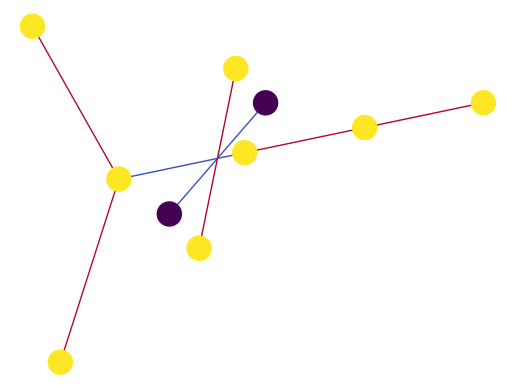

In [160]:
from graphxai.explainers import GNNExplainer as GXAI
data = subgraph_string[0]
gnnex = GXAI(model_s)
gnnex_exp = gnnex.get_explanation_graph(x = data.x, edge_index = data.edge_index)
gnnex_exp.visualize_graph(ax = None, show = False, agg_nodes = torch.mean)
plt.savefig('PRAD_hrd_STRING_xai.pdf')
plt.show()

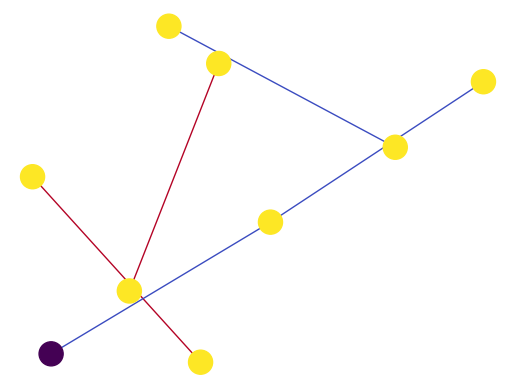

In [165]:
data = subgraph_distance[0]
gnnex = GXAI(model_d)
gnnex_exp = gnnex.get_explanation_graph(x = data.x, edge_index = data.edge_index, forward_kwargs = {'edge_attr':data.edge_attr})
gnnex_exp.visualize_graph(ax = None, show = False, agg_nodes = torch.mean)
#plt.savefig('PRAD_hrd_distance_xai.pdf')
plt.show()

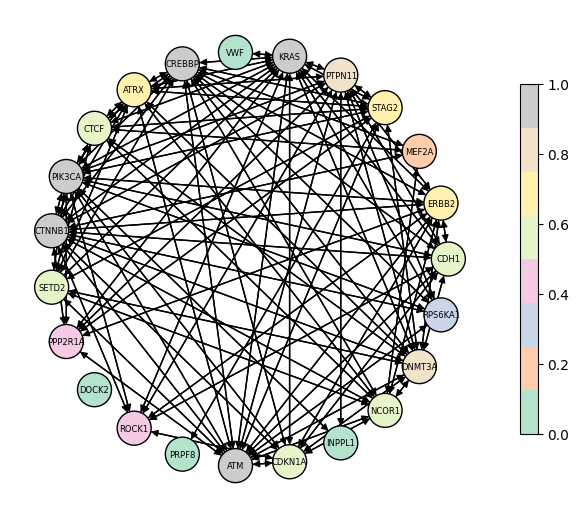

In [96]:
#data = subgraph_distance[0]
data = subgraph_string[0]

def visualize_graph(graph, gene_pairs):
    vis = to_networkx(graph)
    degree = nx.degree_centrality(vis)
    plt.figure(1, figsize=(6, 5))
    nx.draw(vis,pos = nx.circular_layout(vis),edgecolors='black',cmap=plt.get_cmap('Pastel2'),node_color=list(degree.values()),font_size=6,node_size=600, linewidths=1, labels = gene_pairs)
    cmap = plt.get_cmap('Pastel2')
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_position([0.85, 0.15, 0.05, 0.7])
visualize_graph(data, gene_pair_new)
plt.savefig('KICH_string_im_subgraph.pdf')
plt.show()

In [97]:
404+1004+244+181+596+288+359+434+477+419+177+494+102+406

5585

In [102]:
graphs_string[0].edge_index

tensor([[  0,   0,   0,  ..., 251, 251, 251],
        [  1,   6,   7,  ..., 232, 244, 246]])

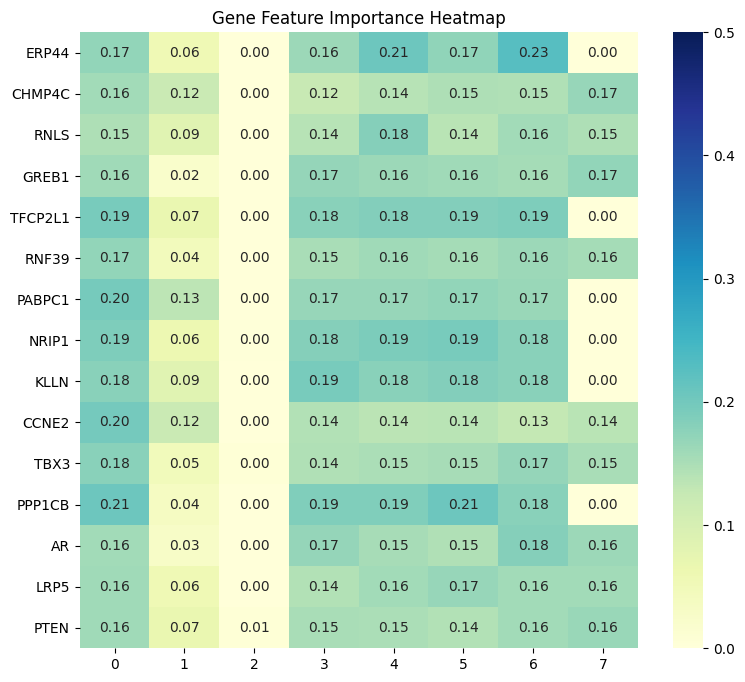

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dictionary gene_pair_new with gene names
# Initialize an empty DataFrame to store feature importances
importance_df = pd.DataFrame()

# Loop through each gene of interest
for gene_index, gene_name in gene_pair_new.items():
    # Create a list to store data for the given gene from each dataframe
    gene_data_list = []

    # Loop through each dataframe
    for df in feats:
        # Check if the given gene is in the dataframe columns
        if gene_name in df.columns:
            # Extract data for the given gene and store it in the list
            gene_data = df[gene_name]
            
            # If the gene_data is categorical, encode it using LabelEncoder
            if gene_data.dtype == 'object':
                label_encoder = LabelEncoder()
                gene_data = label_encoder.fit_transform(gene_data)
            
            gene_data_list.append(gene_data)

    # Create a new dataframe with rows of samples and columns of features for the given gene
    gene_df = pd.DataFrame({f'{gene_name}{i}': data for i, data in enumerate(gene_data_list)})

    # Load your dataframe with the label column and omics features
    # Replace 'your_dataframe.csv' with your actual data file

    # Extract features (omics data) and labels
    y = Label.dropna()
    gene_df = gene_df.reindex(y.index)
    X = gene_df

    # Initialize the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=0)

    # Fit the classifier to your data
    clf.fit(X, y)

    # Get feature importance scores
    feature_importance = clf.feature_importances_

    # Add the feature importance values to the importance_df
    importance_df[f'{gene_name}'] = feature_importance

# Transpose the DataFrame to have genes as rows and features as columns
importance_df = importance_df.transpose()

# Create a heatmap for the concatenated dataframe
plt.figure(figsize=(9, 8))
sns.heatmap(data=importance_df,
            cmap="YlGnBu", annot=True, fmt=".2f",vmin=0, vmax=0.5)
plt.title("Gene Feature Importance Heatmap")
plt.savefig('PRAD_hrd_map.pdf')
plt.show()

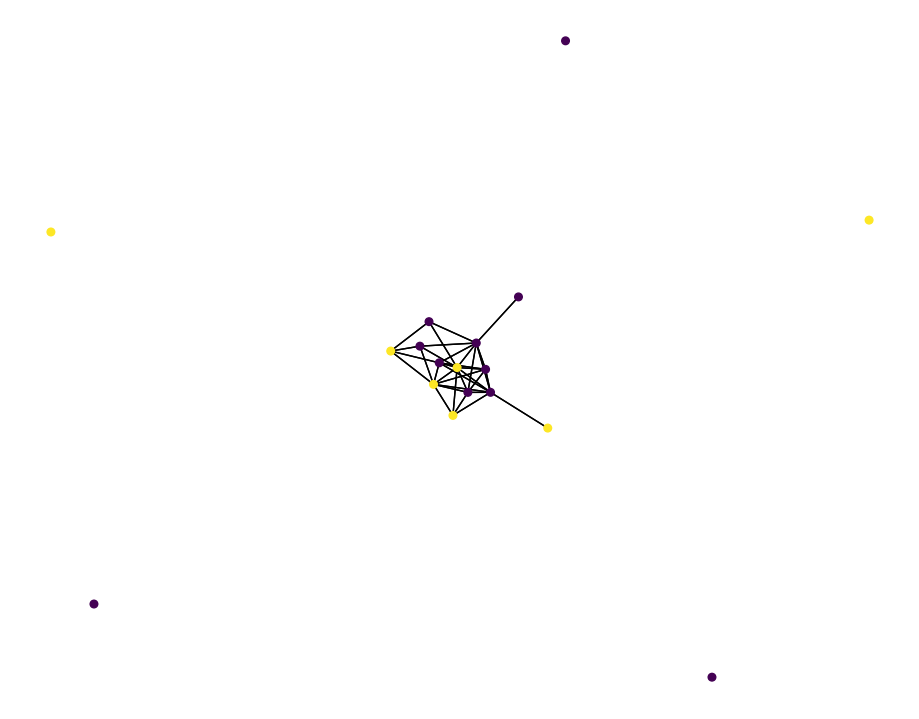

In [1354]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
    
g, y = convert_to_networkx(subgraph, n_sample=18)
plot_graph(g, y)

In [1371]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.1,num_test=0.2)
data = split(subgraph)
data

Data(x=[18, 8], edge_index=[2, 68], y=[18], train_mask=[18], val_mask=[18], test_mask=[18])